In [4]:
import pandas as pd

In [5]:
df = pd.read_csv('resultado_unificado.csv')

In [8]:
df['Especie'].unique()

array(['ALMEJA', 'ATUN', 'BANDERA', 'BAQUETA', 'BARRILETE', 'BERRUGATA',
       'BONITO', 'CABRILLA', 'CALAMAR', 'CAMARON', 'CARACOL', 'CAZON',
       'CHARAL', 'CORVINA', 'ERIZO', 'ESMEDREGAL', 'GUACHINANGO', 'JAIBA',
       'JUREL', 'LANGOSTA', 'LEBRANCHA', 'LENGUADO', 'LISA', 'LOBINA',
       'MERO', 'MOJARRA', 'OSTION', 'OTRAS', 'PAMPANO', 'PARGO', 'PIERNA',
       'PULPO', 'RAYA Y SIMILARES', 'ROBALO', 'RONCO', 'SARDINA',
       'SARGAZO', 'SIERRA', 'TIBURON'], dtype=object)

In [18]:
from scripts.species_classifier import classify_species

habitat_groups = {
    # Benthic invertebrates
    'ALMEJA': 'Benthic invertebrates',
    'CAMARON': 'Benthic invertebrates',
    'JAIBA': 'Benthic invertebrates',
    'CARACOL': 'Benthic invertebrates',
    'LANGOSTA': 'Benthic invertebrates',
    'PULPO': 'Benthic invertebrates',
    'ERIZO': 'Benthic invertebrates',
    'OSTION': 'Benthic invertebrates',
    'PEPINO DE MAR': 'Benthic invertebrates',
    'ABULON': 'Benthic invertebrates',
    
    # Pelagic fish
    'ATUN': 'Pelagic fish',
    'BARRILETE': 'Pelagic fish',
    'BONITO': 'Pelagic fish',
    'JUREL': 'Pelagic fish',
    'PAMPANO': 'Pelagic fish',
    'SIERRA': 'Pelagic fish',
    'SARDINA': 'Pelagic fish',
    'TIBURON': 'Pelagic fish',
    
    # Demersal fish
    'BERRUGATA': 'Demersal fish',
    'MERO': 'Demersal fish',
    'BAQUETA': 'Demersal fish',
    'CORVINA': 'Demersal fish',
    
    # Benthopelagic fish
    'LOBINA': 'Benthopelagic fish',
    'RONCO': 'Benthopelagic fish',
    'LISA': 'Benthopelagic fish',
    'MOJARRA': 'Benthopelagic fish',
    'BANDERA': 'Benthopelagic fish',
    
    # Reef fish
    'CABRILLA': 'Reef fish',
    'HUACHINANGO': 'Reef fish',
    'ESMEDREGAL': 'Reef fish',
    'PARGO': 'Reef fish',
    'PIERNA': 'Reef fish',
    'RUBIA': 'Reef fish',
    'VILLAJAIBA': 'Reef fish',
    'ROBALO': 'Reef fish',
    
    # Benthic fish
    'LENGUADO': 'Benthic fish',
    'RAYA Y SIMILARES': 'Benthic fish',
    
    # Other
    'SARGAZO': 'Other',
    'OTRAS': 'Other'
}

# Ruta al archivo con datos de especies
file_path = 'resultado_unificado.csv'

# Llamar a la función
classified_data = classify_species(file_path, habitat_groups, output_path='future_catches.csv')

Archivo clasificado guardado en: future_catches.csv


C:\Users\ricar\AppData\Local\Temp\ipykernel_10260\2002757736.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shap_long_filtered['shap_value'] = pd.to_numeric(shap_long_filtered['shap_value'], errors='coerce')


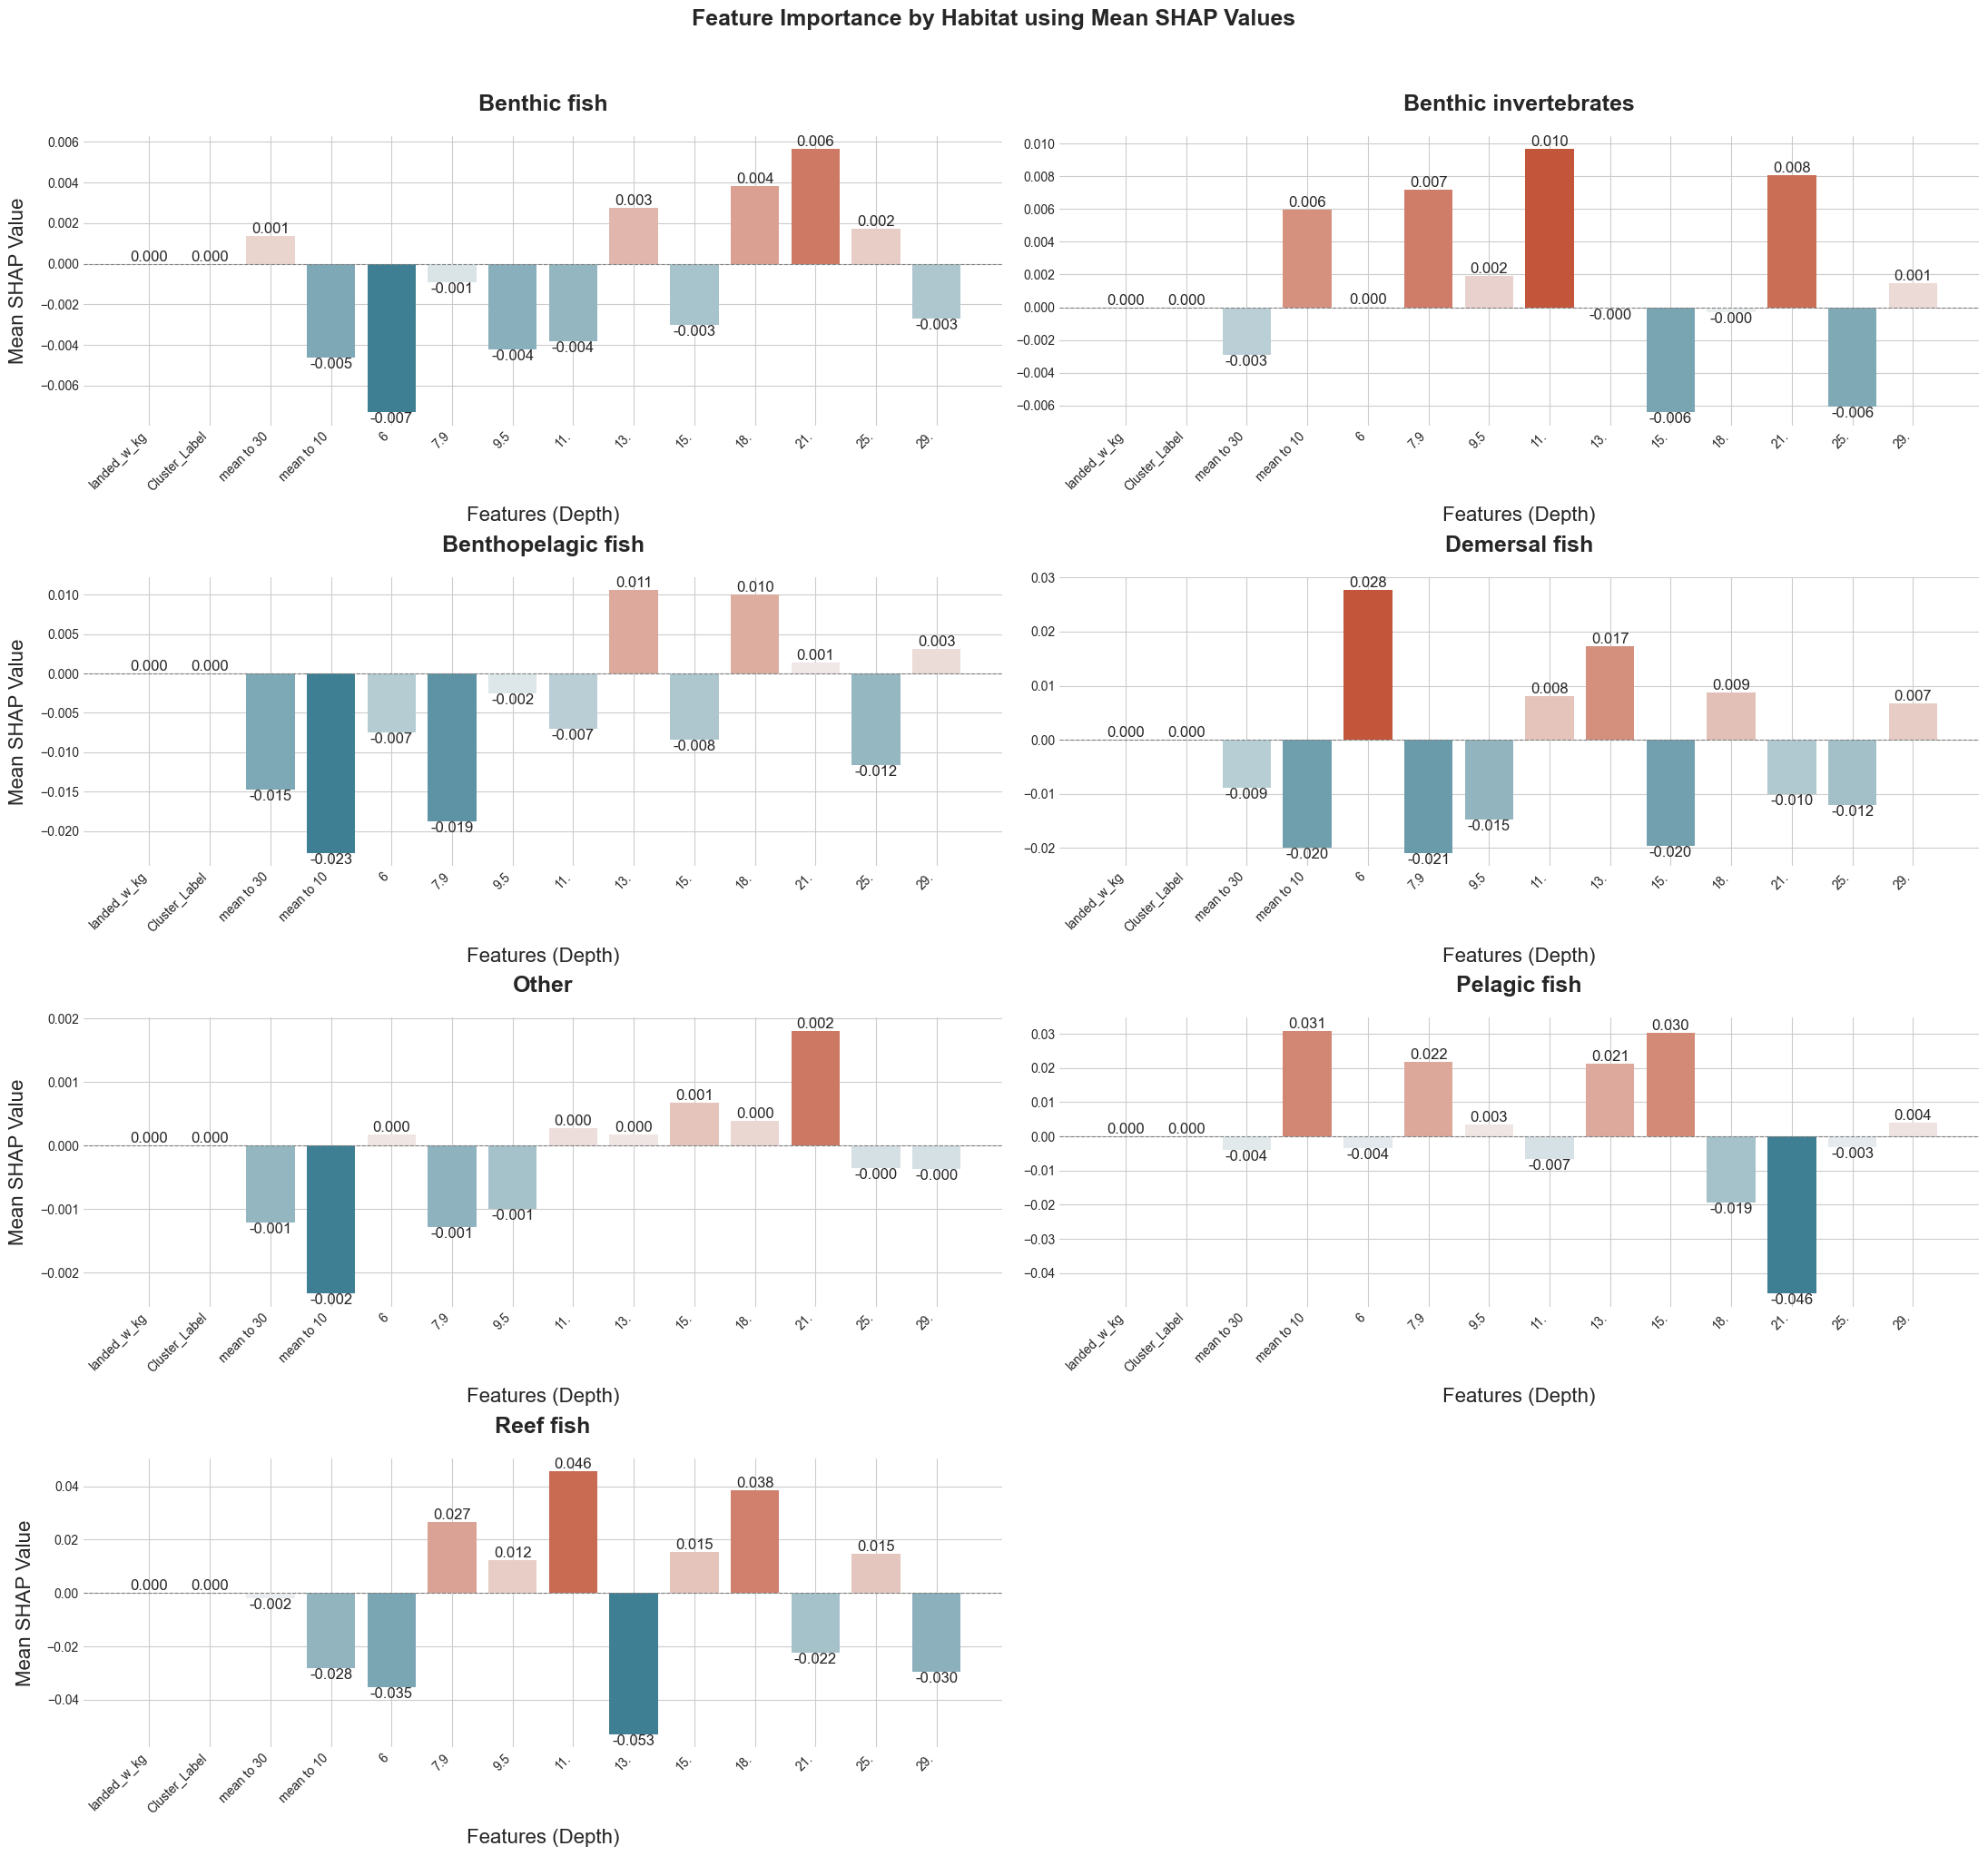

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

# Load the dataset
file_path = 'shap_analysis_results_clasified.csv'
shap_data = pd.read_csv(file_path)

# Function to extract depth from feature name
def extract_depth(feature):
    depth_match = re.findall(r'(\d+)m', feature)
    return int(depth_match[0]) if depth_match else 0

# Rename columns for better visualization
columns_to_rename = shap_data.columns.difference(['species', 'cluster', 'habitat'])
shap_data.rename(columns={
    col: (col.replace('thetao_sfc=', '')[:3] if col.startswith('thetao_sfc=') else col)
        .replace('mean_temp_30m', 'mean to 30')
        .replace('mean_temp_10m', 'mean to 10')
        .replace('_m', 'm') 
    for col in columns_to_rename
}, inplace=True)

# Prepare the data
shap_long = shap_data.melt(
    id_vars=['species', 'cluster', 'habitat'],
    var_name='feature',
    value_name='shap_value'
)
shap_long_filtered = shap_long.dropna(subset=['habitat'])
shap_long_filtered['shap_value'] = pd.to_numeric(shap_long_filtered['shap_value'], errors='coerce')
shap_long_filtered = shap_long_filtered.dropna(subset=['shap_value'])

# Set style
plt.style.use('seaborn-v0_8-whitegrid')

# Create figure and subplots
habitats = sorted(shap_long_filtered['habitat'].unique())
n_cols = 2
n_rows = int(np.ceil(len(habitats) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(22, 5*n_rows), squeeze=False)

# Custom diverging color map
custom_cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Flatten axes for easier iteration
axes_flat = axes.flatten()

for i, habitat in enumerate(habitats):
    habitat_data = shap_long_filtered[shap_long_filtered['habitat'] == habitat]
    
    # Sort features by depth
    feature_order = sorted(habitat_data['feature'].unique(), key=extract_depth)
    
    # Calculate mean SHAP values
    plot_data = habitat_data.groupby('feature')['shap_value'].mean().reindex(feature_order)
    
    # Create the plot with diverging colors
    ax = axes_flat[i]
    bars = ax.bar(
        plot_data.index,
        plot_data.values,
        color=[custom_cmap(0.5 + 0.5 * np.sign(val) * abs(val)/max(abs(plot_data))) for val in plot_data]
    )
    
    # Style the subplot
    ax.set_title(habitat, fontsize=18, fontweight='bold', pad=20)
    ax.set_xlabel('Features (Depth)', fontsize=16, labelpad=10)
    if i % 2 == 0:
        ax.set_ylabel('Mean SHAP Value', fontsize=16, labelpad=10)
    
    # Rotate labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Add zero reference line
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2.,
            height,
            f'{height:.3f}',
            ha='center',
            va='bottom' if height >= 0 else 'top',
            fontsize=12
        )
    
    # Clean up spines
    sns.despine(ax=ax, left=True, bottom=True)

# Remove empty subplots
for j in range(i+1, len(axes_flat)):
    fig.delaxes(axes_flat[j])

# Adjust layout
plt.tight_layout()

# Add main title
fig.suptitle(
    'Feature Importance by Habitat using Mean SHAP Values',
    fontsize=18,
    fontweight='bold',
    y=1.02
)

# Final adjustments
plt.subplots_adjust(top=0.95)

# Show the plot
plt.show()

fig.savefig('Feature Importance by habitat.svg', format='svg', bbox_inches='tight', dpi=300)

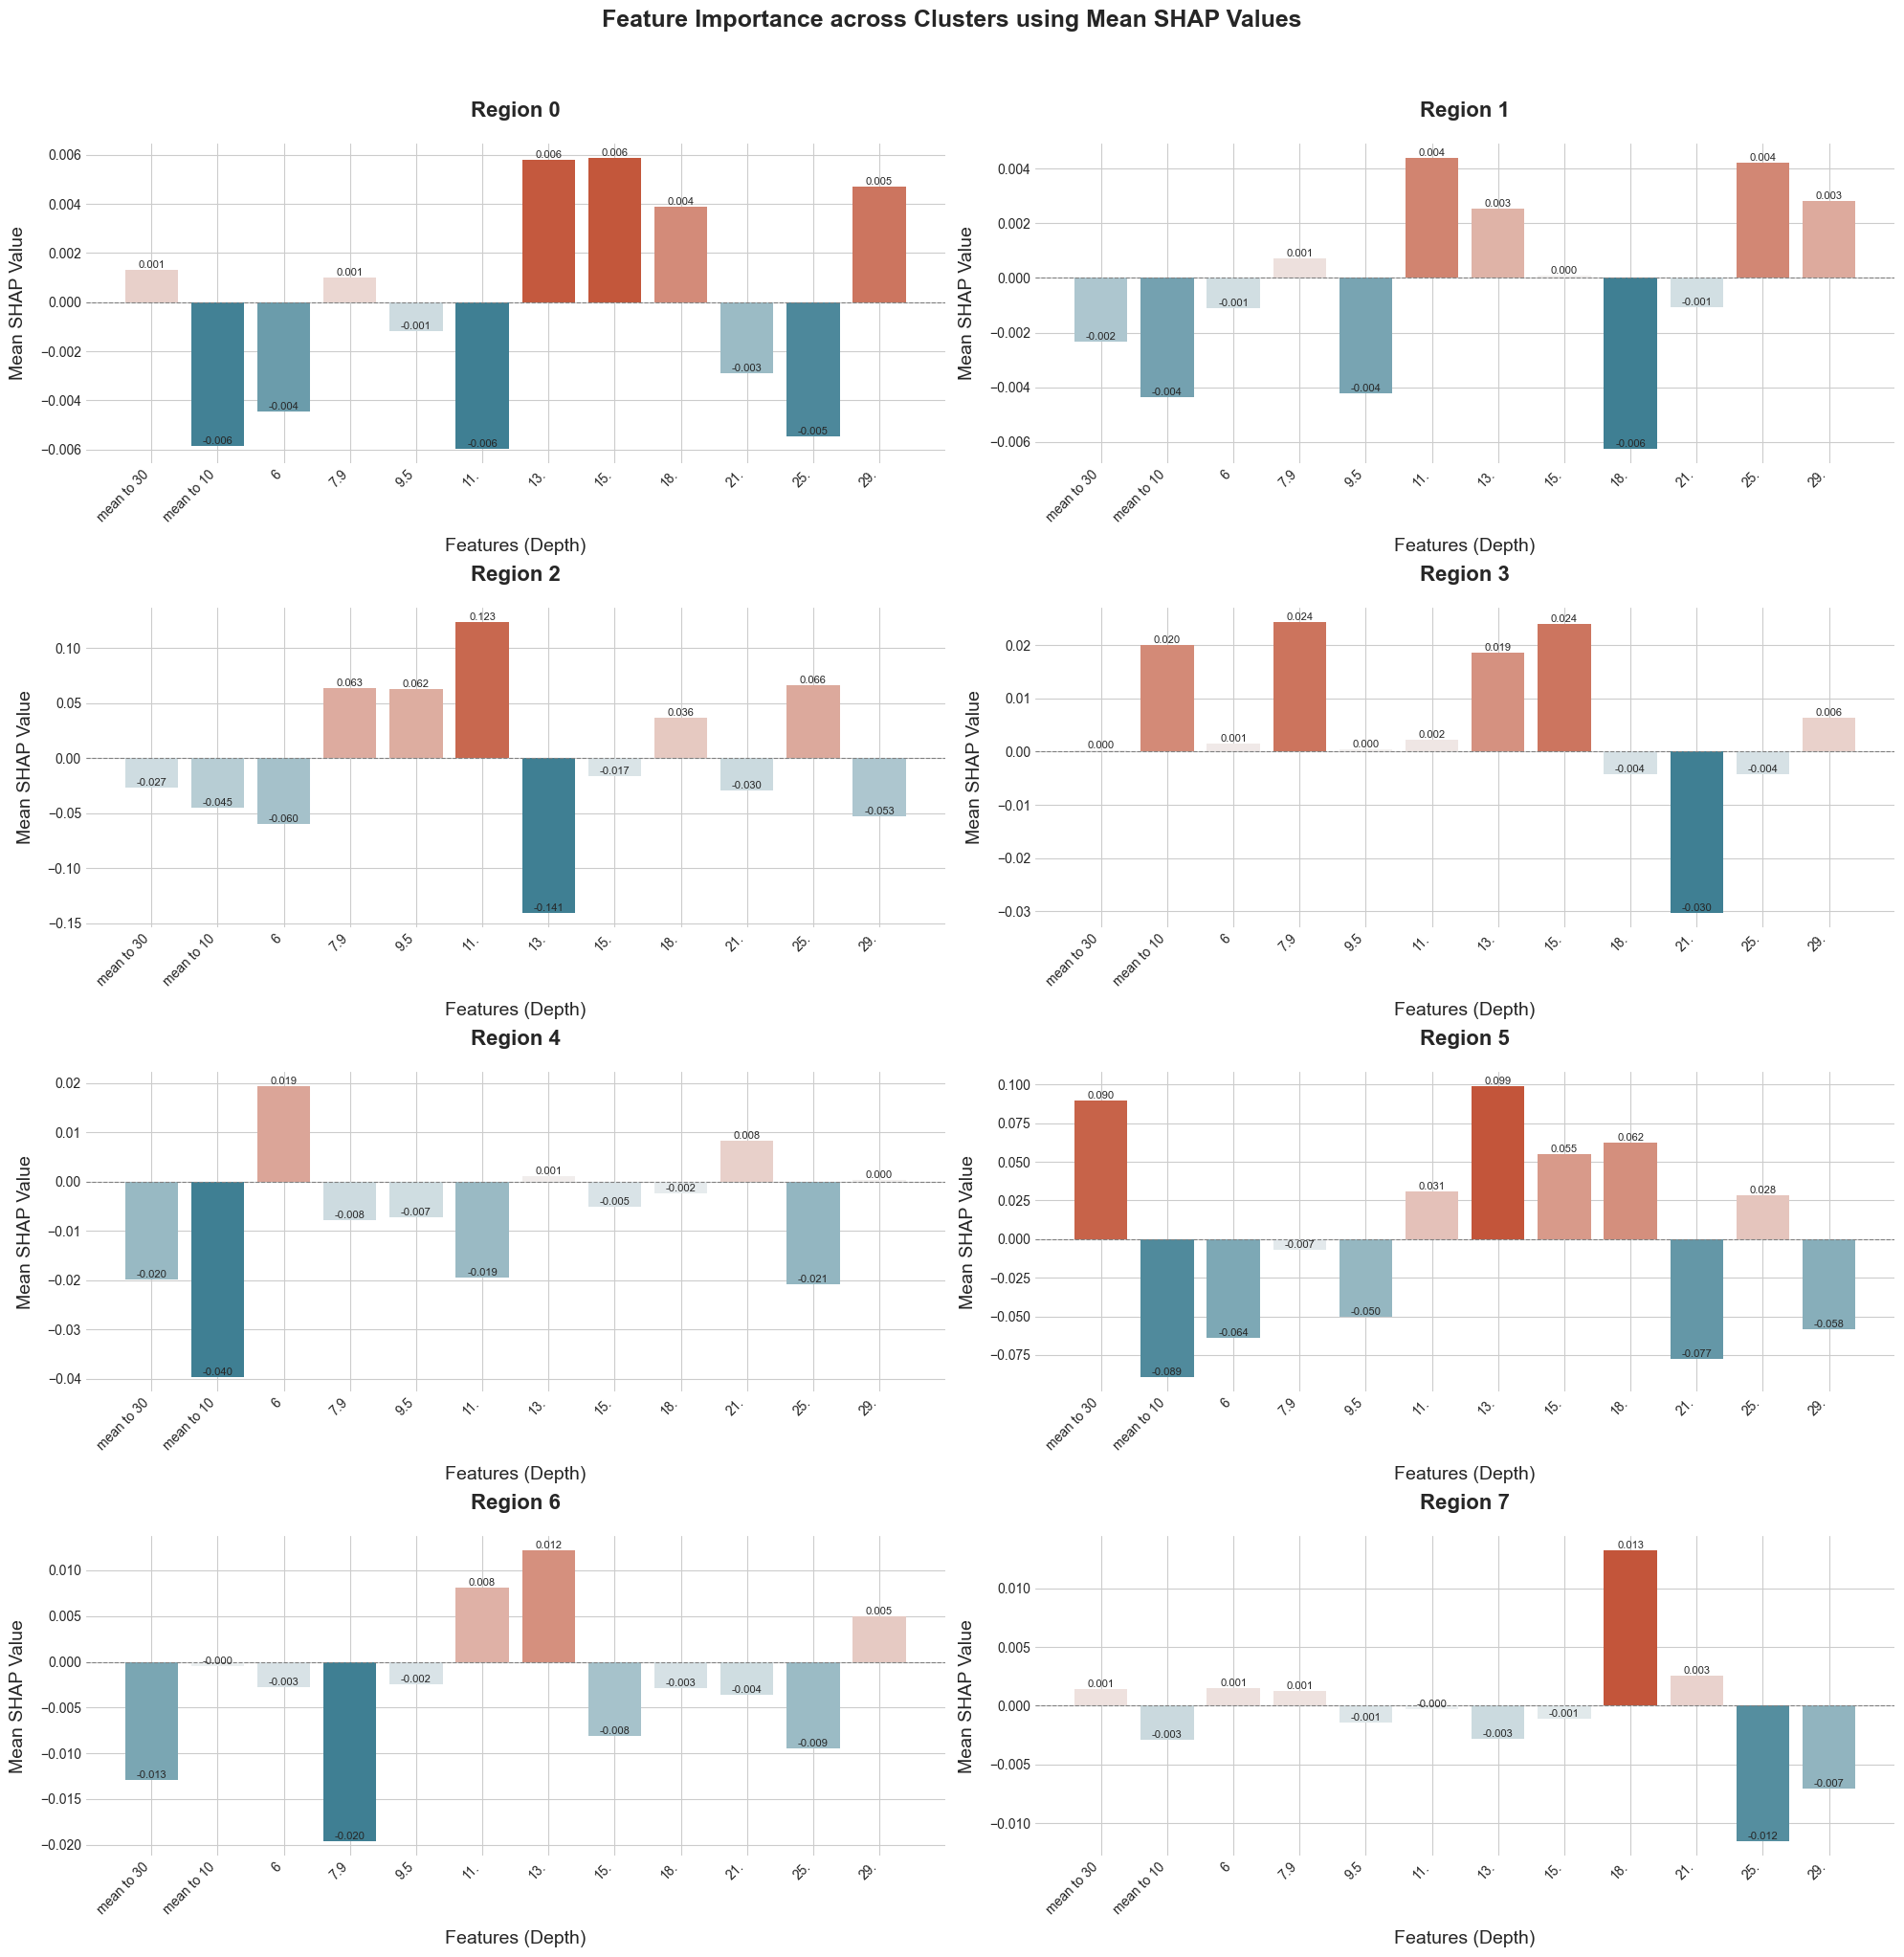

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

# Load the dataset
file_path = 'shap_analysis_results_clasified.csv'
shap_data = pd.read_csv(file_path)

# Function to extract depth from feature name
def extract_depth(feature):
    # Look for numbers in the feature name, considering both formats
    depth_match = re.findall(r'(\d+)m', feature)
    return int(depth_match[0]) if depth_match else 0

# Rename columns to shorter names for better visualization, except specific columns
columns_to_rename = shap_data.columns.difference(['species', 'cluster', 'habitat'])
shap_data.rename(columns={col: (col.replace('thetao_sfc=', '')[:3] if col.startswith('thetao_sfc=') else col)
                                .replace('mean_temp_30m', 'mean to 30')
                                .replace('mean_temp_10m', 'mean to 10')
                                .replace('_m', 'm') for col in columns_to_rename}, inplace=True)

# Drop the first two columns ('lan' and 'Clu')
shap_data = shap_data.drop(columns=['lan', 'Clu'], errors='ignore')

# Melt the dataframe to long format
shap_long = shap_data.melt(id_vars=['species', 'cluster', 'habitat'], var_name='feature', value_name='shap_value')
shap_long_filtered = shap_long.dropna(subset=['cluster'])

# Remove rows with 'landed_w_kg' and 'cluster' from the feature column
shap_long_filtered = shap_long_filtered[~shap_long_filtered['feature'].isin(['landed_w_kg', 'Cluster_Label'])]

# Convert 'shap_value' column to numeric, forcing errors to NaN and dropping them
shap_long_filtered['shap_value'] = pd.to_numeric(shap_long_filtered['shap_value'], errors='coerce')
shap_long_filtered = shap_long_filtered.dropna(subset=['shap_value'])

# Set a professional color palette and style
plt.style.use('seaborn-v0_8-whitegrid')

# Sort clusters numerically
clusters = sorted(shap_long_filtered['cluster'].unique(), key=int)

# Calculate rows and columns for subplots
n_clusters = len(clusters)
n_cols = 2
n_rows = int(np.ceil(n_clusters / n_cols))

# Create subplots in two columns
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows), squeeze=False)

# Custom color map that transitions from cool blue (negative) to warm red (positive)
custom_cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Flatten axes for easier iteration
axes_flat = axes.flatten()

for i, cluster in enumerate(clusters):
    cluster_data = shap_long_filtered[shap_long_filtered['cluster'] == cluster]
    
    # Sort features by depth (from lowest to highest)
    feature_order = sorted(cluster_data['feature'].unique(), key=extract_depth)
    
    # Prepare data for plotting with depth-ordered features
    plot_data = cluster_data.groupby('feature')['shap_value'].mean().reindex(feature_order)
    
    # Create the plot with more nuanced coloring
    ax = axes_flat[i]
    bars = ax.bar(plot_data.index, plot_data.values, color=[custom_cmap(0.5 + 0.5 * np.sign(val) * abs(val)/max(abs(plot_data))) for val in plot_data])
    
    # Improved formatting
    ax.set_title(f'Region {cluster}', fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Features (Depth)', fontsize=14, labelpad=10)
    ax.set_ylabel('Mean SHAP Value', fontsize=14, labelpad=10)
    
    # Rotate x-axis labels 
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Add zero line for reference
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    # Customize spines
    sns.despine(ax=ax, left=True, bottom=True)

# Remove any unused subplots
for j in range(i+1, len(axes_flat)):
    fig.delaxes(axes_flat[j])

# Adjust layout
plt.tight_layout()

# Add an overall title
fig.suptitle('Feature Importance across Clusters using Mean SHAP Values', 
             fontsize=18, fontweight='bold', y=1.02)

# Improve overall figure aesthetics
plt.subplots_adjust(top=0.95)

# Save the figure to an SVG file
plt.savefig('figures/shap_cluster_analysis.svg', format='svg')

# Show the plot
plt.show()


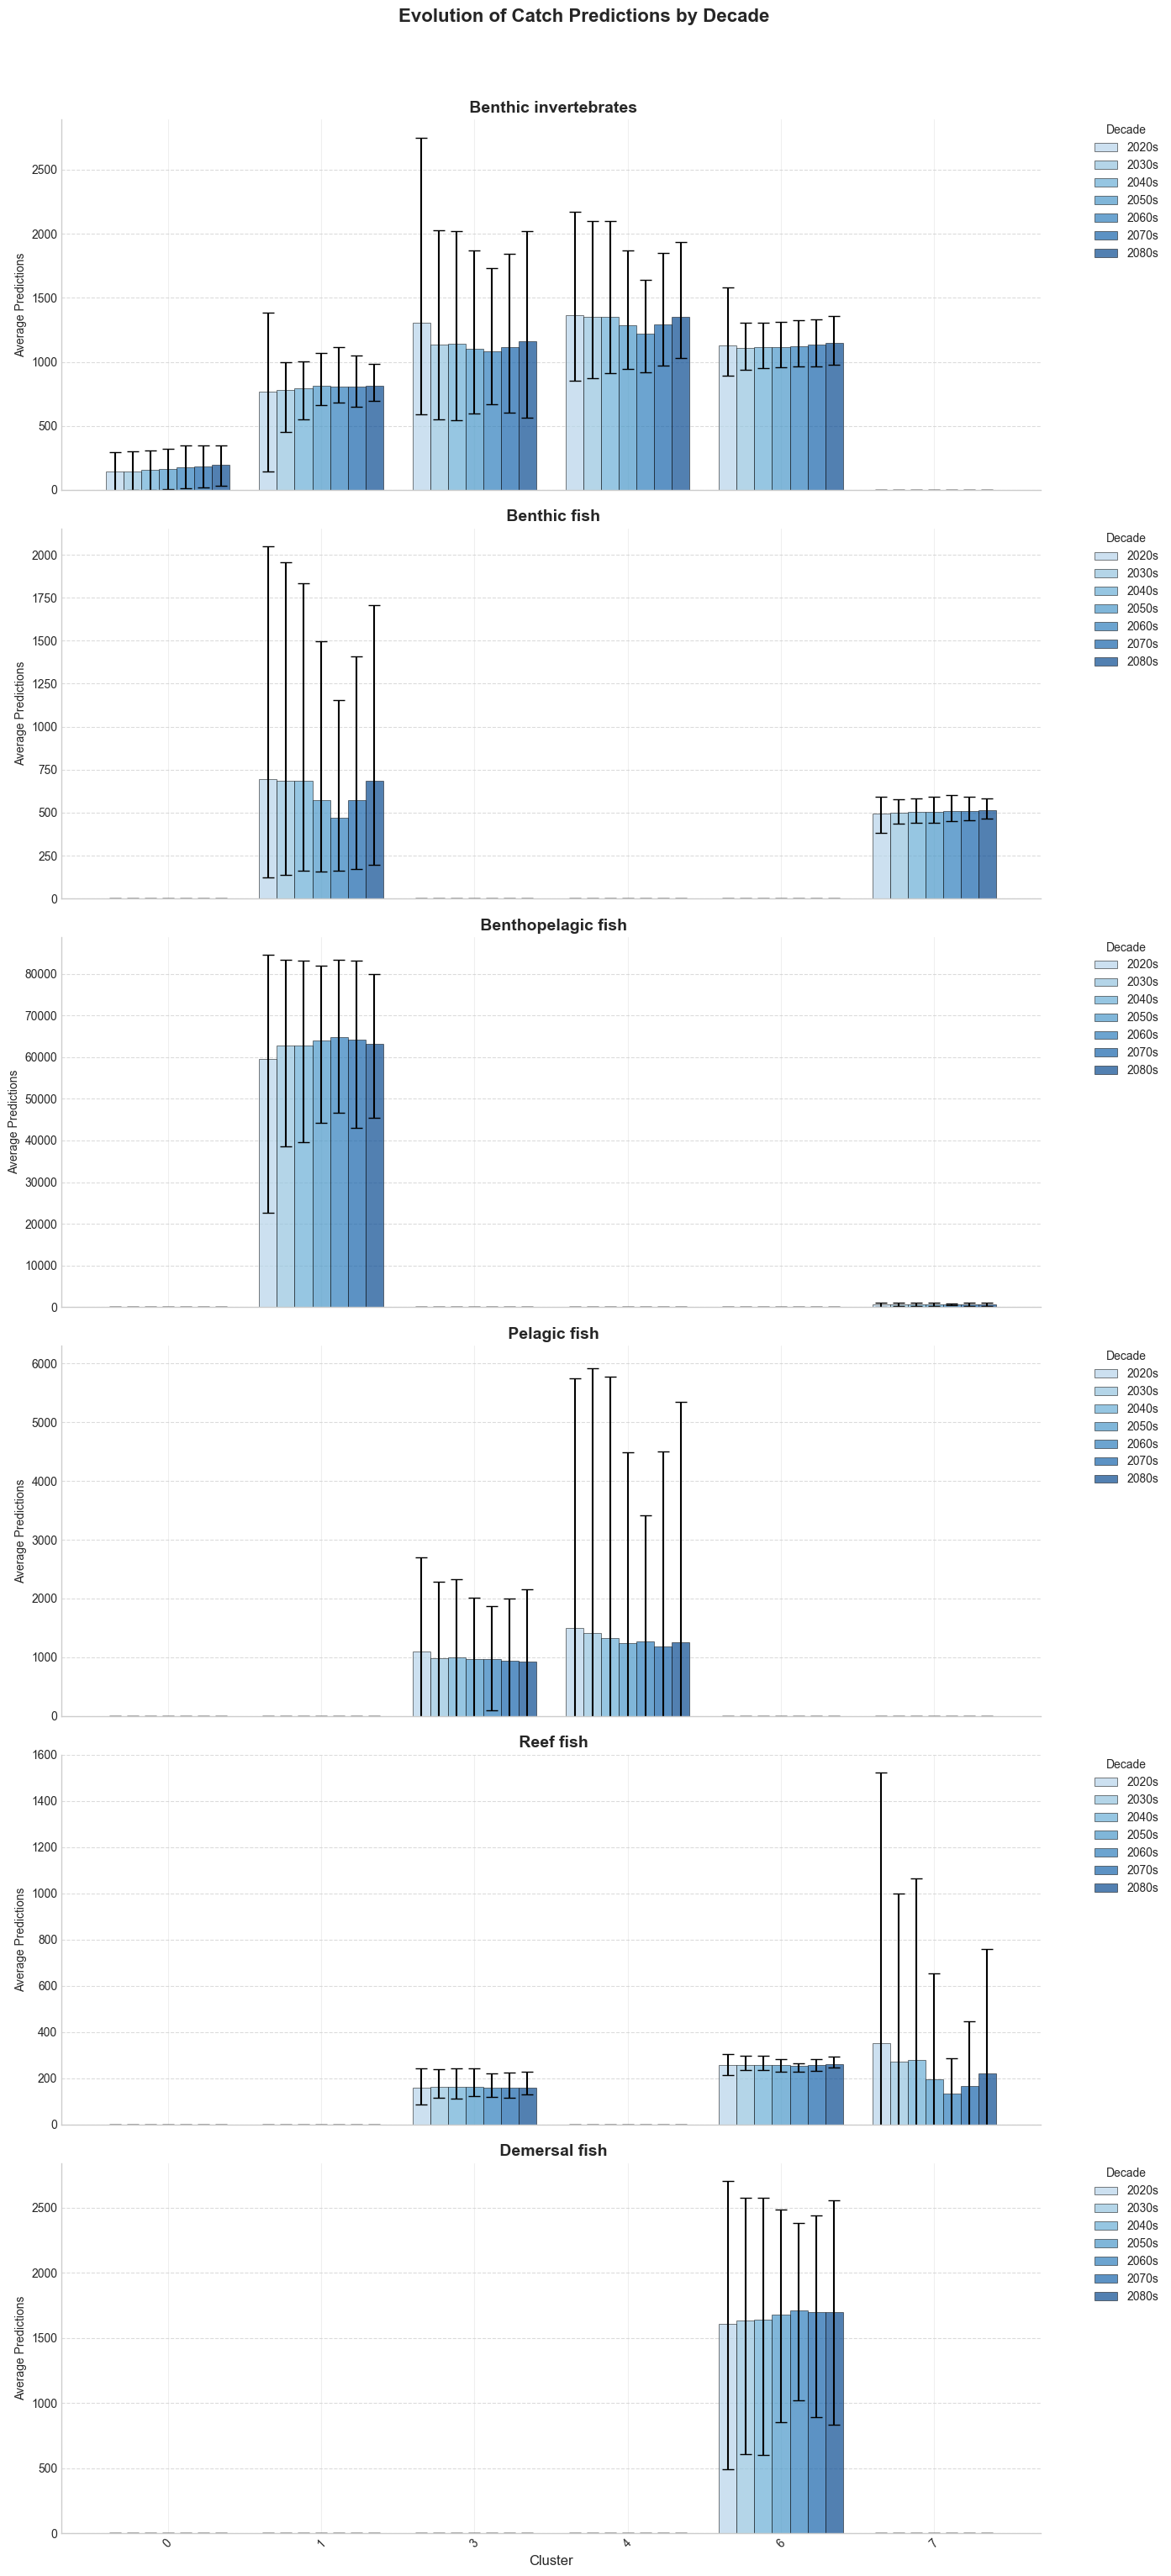

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Figure settings with custom parameters
plt.rcParams.update({
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'figure.figsize': (14, 8),
    'grid.alpha': 0.3
})

# Load and process data
file_path = 'future_catches.csv'
data = pd.read_csv(file_path)

# Data preparation
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
data['decade'] = (data['year'] // 10) * 10

# Calculate annual statistics
annual_stats = data.groupby(['Cluster', 'habitat', 'species', 'year']).agg({
    'predictions': ['mean', 'max', 'min']
}).reset_index()
annual_stats.columns = ['Cluster', 'habitat', 'species', 'year', 'annual_avg_prediction', 'annual_max_prediction', 'annual_min_prediction']

# Calculate decadal statistics
decadal_stats = annual_stats.copy()
decadal_stats['decade'] = (decadal_stats['year'] // 10) * 10

decadal_stats_no_species = decadal_stats.groupby(['Cluster', 'habitat', 'decade']).agg({
    'annual_avg_prediction': 'mean',
    'annual_max_prediction': 'mean',
    'annual_min_prediction': 'mean'
}).reset_index()

# Prepare for visualization
species_groups = decadal_stats_no_species['habitat'].unique()
decades = sorted(decadal_stats_no_species['decade'].unique())
clusters = decadal_stats_no_species['Cluster'].unique()

# Configure figure
fig, axes = plt.subplots(len(species_groups), 1, 
                         figsize=(14, 5 * len(species_groups)), 
                         sharex=True)

# Ensure axes is always a list
axes = np.atleast_1d(axes)

# Custom color palette
decade_colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(decades)))

# Additional spacing between cluster groups
spacing = 0.3

for ax, species_group in zip(axes, species_groups):
    # Clear the previous subplot
    ax.clear()
    
    # Data for the current species group
    group_data = decadal_stats_no_species[decadal_stats_no_species['habitat'] == species_group]
    
    # Bar width and positioning
    width = 0.15
    x = np.arange(len(clusters)) * (1 + spacing)  # Increase the space between cluster groups
    
    # Plot bars for each decade
    for i, decade in enumerate(decades):
        decade_subset = group_data[group_data['decade'] == decade]
        
        # Prepare values for each cluster
        y_values = [decade_subset[decade_subset['Cluster'] == cluster]['annual_avg_prediction'].values[0] 
                    if not decade_subset[decade_subset['Cluster'] == cluster].empty else 0 
                    for cluster in clusters]
        
        y_min = [decade_subset[decade_subset['Cluster'] == cluster]['annual_min_prediction'].values[0] 
                 if not decade_subset[decade_subset['Cluster'] == cluster].empty else 0 
                 for cluster in clusters]
        
        y_max = [decade_subset[decade_subset['Cluster'] == cluster]['annual_max_prediction'].values[0] 
                 if not decade_subset[decade_subset['Cluster'] == cluster].empty else 0 
                 for cluster in clusters]
        
        # Bar positions
        pos = x + i * width - (len(decades) - 1) * width / 2
        
        # Plot bars with error bars
        bars = ax.bar(pos, y_values, width, 
                      label=f'{decade}s', 
                      color=decade_colors[i], 
                      edgecolor='black', 
                      linewidth=0.5,
                      alpha=0.7)
        
        # Add error bars
        ax.errorbar(pos, y_values, 
                    yerr=[np.array(y_values) - np.array(y_min), 
                          np.array(y_max) - np.array(y_values)],
                    fmt='none', 
                    ecolor='black', 
                    capsize=5)
    
    # Customize subplot
    ax.set_title(f" {species_group.capitalize()}", 
                 fontsize=14, fontweight='bold')
    ax.set_ylabel("Average Predictions", fontsize=10)
    ax.set_ylim(bottom=0)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Legend
    ax.legend(title="Decade", 
              bbox_to_anchor=(1.05, 1), 
              loc='upper left', 
              borderaxespad=0.)

# Final configuration of the x-axis
axes[-1].set_xlabel("Cluster", fontsize=12)
axes[-1].set_xticks(x)
axes[-1].set_xticklabels(clusters, rotation=45)

# Final adjustments to the figure
plt.suptitle("Evolution of Catch Predictions by Decade", 
             fontsize=16, 
             fontweight='bold', 
             y=1.02)
plt.tight_layout()

# Save the figure to an SVG file
plt.savefig('catch_predictions.svg', format='svg')

# Show the figure
plt.show()


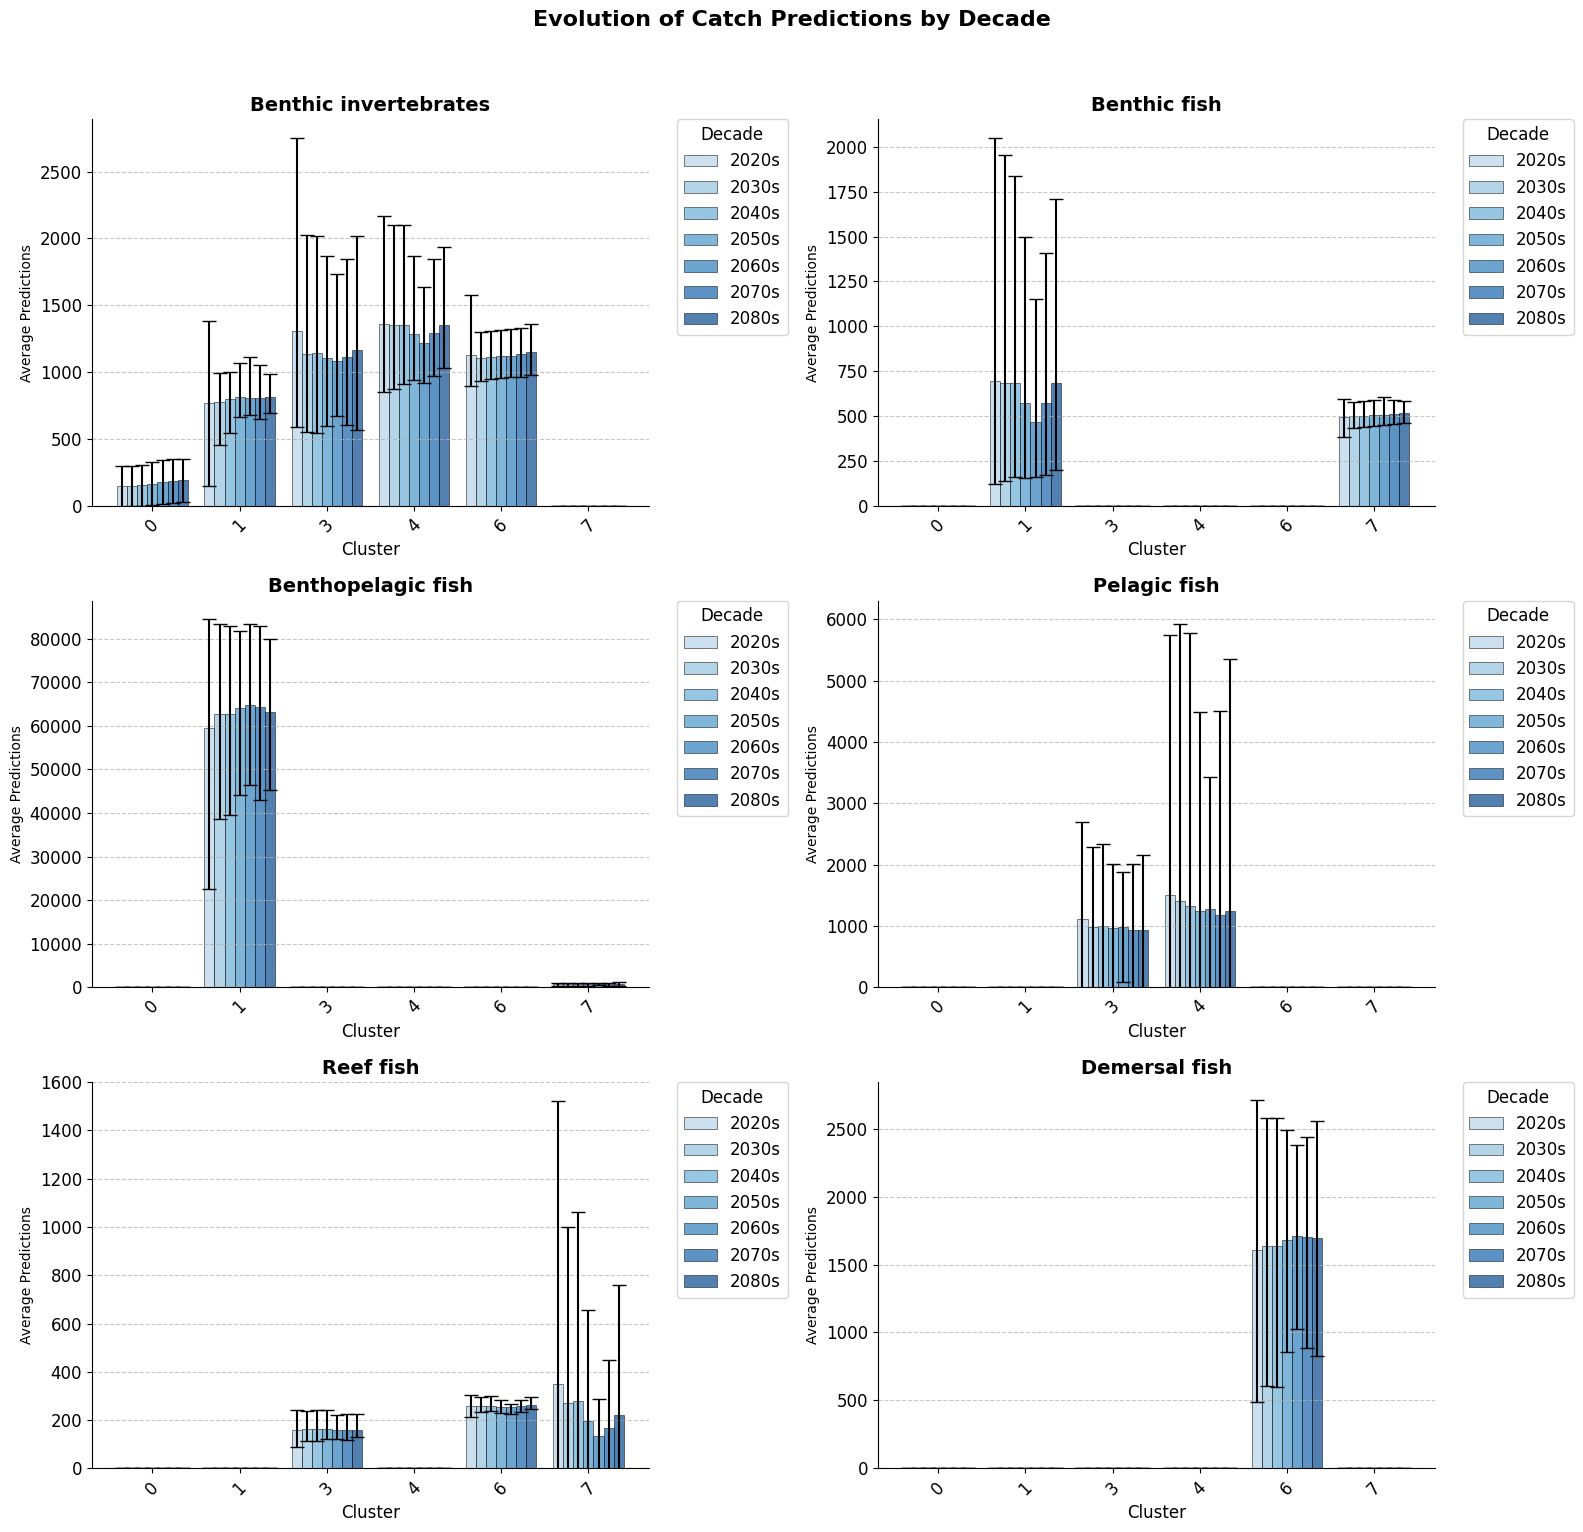

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Figure settings with custom parameters
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.labelsize': 12,
    'figure.figsize': (16, 8),
    'grid.alpha': 0.3
})

# Load and process data
file_path = 'future_catches.csv'
data = pd.read_csv(file_path)

# Data preparation
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
data['decade'] = (data['year'] // 10) * 10

# Calculate annual statistics
annual_stats = data.groupby(['Cluster', 'habitat', 'species', 'year']).agg({
    'predictions': ['mean', 'max', 'min']
}).reset_index()
annual_stats.columns = ['Cluster', 'habitat', 'species', 'year', 'annual_avg_prediction', 'annual_max_prediction', 'annual_min_prediction']

# Calculate decadal statistics
decadal_stats = annual_stats.copy()
decadal_stats['decade'] = (decadal_stats['year'] // 10) * 10

decadal_stats_no_species = decadal_stats.groupby(['Cluster', 'habitat', 'decade']).agg({
    'annual_avg_prediction': 'mean',
    'annual_max_prediction': 'mean',
    'annual_min_prediction': 'mean'
}).reset_index()

# Prepare for visualization
species_groups = decadal_stats_no_species['habitat'].unique()
decades = sorted(decadal_stats_no_species['decade'].unique())
clusters = decadal_stats_no_species['Cluster'].unique()

# Configure figure with subplots in two columns
n_species = len(species_groups)
n_cols = 2
n_rows = int(np.ceil(n_species / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5 * n_rows))

# Ensure axes is always a list
axes = axes.flatten()

# Custom color palette
decade_colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(decades)))

# Additional spacing between cluster groups
spacing = 0.3

for i, (ax, species_group) in enumerate(zip(axes, species_groups)):
    # Data for the current species group
    group_data = decadal_stats_no_species[decadal_stats_no_species['habitat'] == species_group]
    
    # Bar width and positioning
    width = 0.15
    x = np.arange(len(clusters)) * (1 + spacing)  # Increase the space between cluster groups
    
    # Plot bars for each decade
    for j, decade in enumerate(decades):
        decade_subset = group_data[group_data['decade'] == decade]
        
        # Prepare values for each cluster
        y_values = [decade_subset[decade_subset['Cluster'] == cluster]['annual_avg_prediction'].values[0] 
                    if not decade_subset[decade_subset['Cluster'] == cluster].empty else 0 
                    for cluster in clusters]
        
        y_min = [decade_subset[decade_subset['Cluster'] == cluster]['annual_min_prediction'].values[0] 
                 if not decade_subset[decade_subset['Cluster'] == cluster].empty else 0 
                 for cluster in clusters]
        
        y_max = [decade_subset[decade_subset['Cluster'] == cluster]['annual_max_prediction'].values[0] 
                 if not decade_subset[decade_subset['Cluster'] == cluster].empty else 0 
                 for cluster in clusters]
        
        # Bar positions
        pos = x + j * width - (len(decades) - 1) * width / 2
        
        # Plot bars with error bars
        bars = ax.bar(pos, y_values, width, 
                      label=f'{decade}s', 
                      color=decade_colors[j], 
                      edgecolor='black', 
                      linewidth=0.5,
                      alpha=0.7)
        
        # Add error bars
        ax.errorbar(pos, y_values, 
                    yerr=[np.array(y_values) - np.array(y_min), 
                          np.array(y_max) - np.array(y_values)],
                    fmt='none', 
                    ecolor='black', 
                    capsize=5)
    
    # Customize subplot
    ax.set_title(f"{species_group.capitalize()}", fontsize=14, fontweight='bold')
    ax.set_ylabel("Average Predictions", fontsize=10)
    ax.set_ylim(bottom=0)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Set x-axis labels for each subplot
    ax.set_xlabel("Cluster", fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(clusters, rotation=45)

    # Legend
    ax.legend(title="Decade", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Remove any unused subplots if there are fewer species groups than subplots available
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Final adjustments to the figure
plt.suptitle("Evolution of Catch Predictions by Decade", fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()

# Save the figure to an SVG file
plt.savefig('figures/Catch_predictions.svg', format='svg')

# Show the figure
plt.show()


In [16]:
# Previous code remains the same until the create_statistical_tables function

def create_statistical_tables(data, decadal_stats_no_species):
    # Instead of a dictionary, we'll create a list to store all tables
    all_tables = []
    
    for habitat in decadal_stats_no_species['habitat'].unique():
        # Filter data for current habitat
        habitat_data = decadal_stats_no_species[decadal_stats_no_species['habitat'] == habitat]
        
        # Create a list to store table rows
        table_data = []
        
        # For each cluster and decade combination
        for cluster in habitat_data['Cluster'].unique():
            cluster_data = habitat_data[habitat_data['Cluster'] == cluster]
            
            for decade in cluster_data['decade'].unique():
                decade_data = cluster_data[cluster_data['decade'] == decade]
                
                # Calculate mode from original data
                original_decade_data = data[
                    (data['habitat'] == habitat) & 
                    (data['Cluster'] == cluster) & 
                    (data['decade'] == decade)
                ]
                mode_value = calculate_mode(original_decade_data)
                
                # Get yearly values for the decade
                yearly_values = get_decade_yearly_values(data, habitat, cluster, decade)
                
                row = {
                    'Habitat': habitat,  # Add habitat to each row
                    'Cluster': cluster,
                    'Decade': f"{int(decade)}s",
                    'Maximum': round(decade_data['annual_max_prediction'].iloc[0], 2),
                    'Minimum': round(decade_data['annual_min_prediction'].iloc[0], 2),
                    'Mode': round(mode_value, 2),
                    'Mean': round(decade_data['annual_avg_prediction'].iloc[0], 2)
                }
                
                # Add yearly values to the row
                for year, value in yearly_values.items():
                    row[f'Year_{year}'] = value
                
                table_data.append(row)
        
        # Add all rows to the main list
        all_tables.extend(table_data)
    
    # Convert all data to a single DataFrame
    combined_table = pd.DataFrame(all_tables)
    
    # Reorder columns to put habitat first, then other columns, and years at the end
    year_cols = [col for col in combined_table.columns if col.startswith('Year_')]
    other_cols = [col for col in combined_table.columns if not col.startswith('Year_')]
    other_cols.remove('Habitat')  # Remove Habitat from other_cols
    combined_table = combined_table[['Habitat'] + other_cols + sorted(year_cols)]
    
    return combined_table

# Create statistical table
statistical_table = create_statistical_tables(data, decadal_stats_no_species)

# Save the combined table to CSV
statistical_table.to_csv('combined_statistics.csv', index=False)

# Print table (optional, for verification)
print("\nCombined Statistical Table:")
print(tabulate(statistical_table, headers='keys', tablefmt='grid', showindex=False))
print("\n" + "="*80)

# Rest of the visualization code remains the same


Combined Statistical Table:
+-----------------------+-----------+----------+-----------+-----------+-----------+----------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
| Habitat               |   Cluster

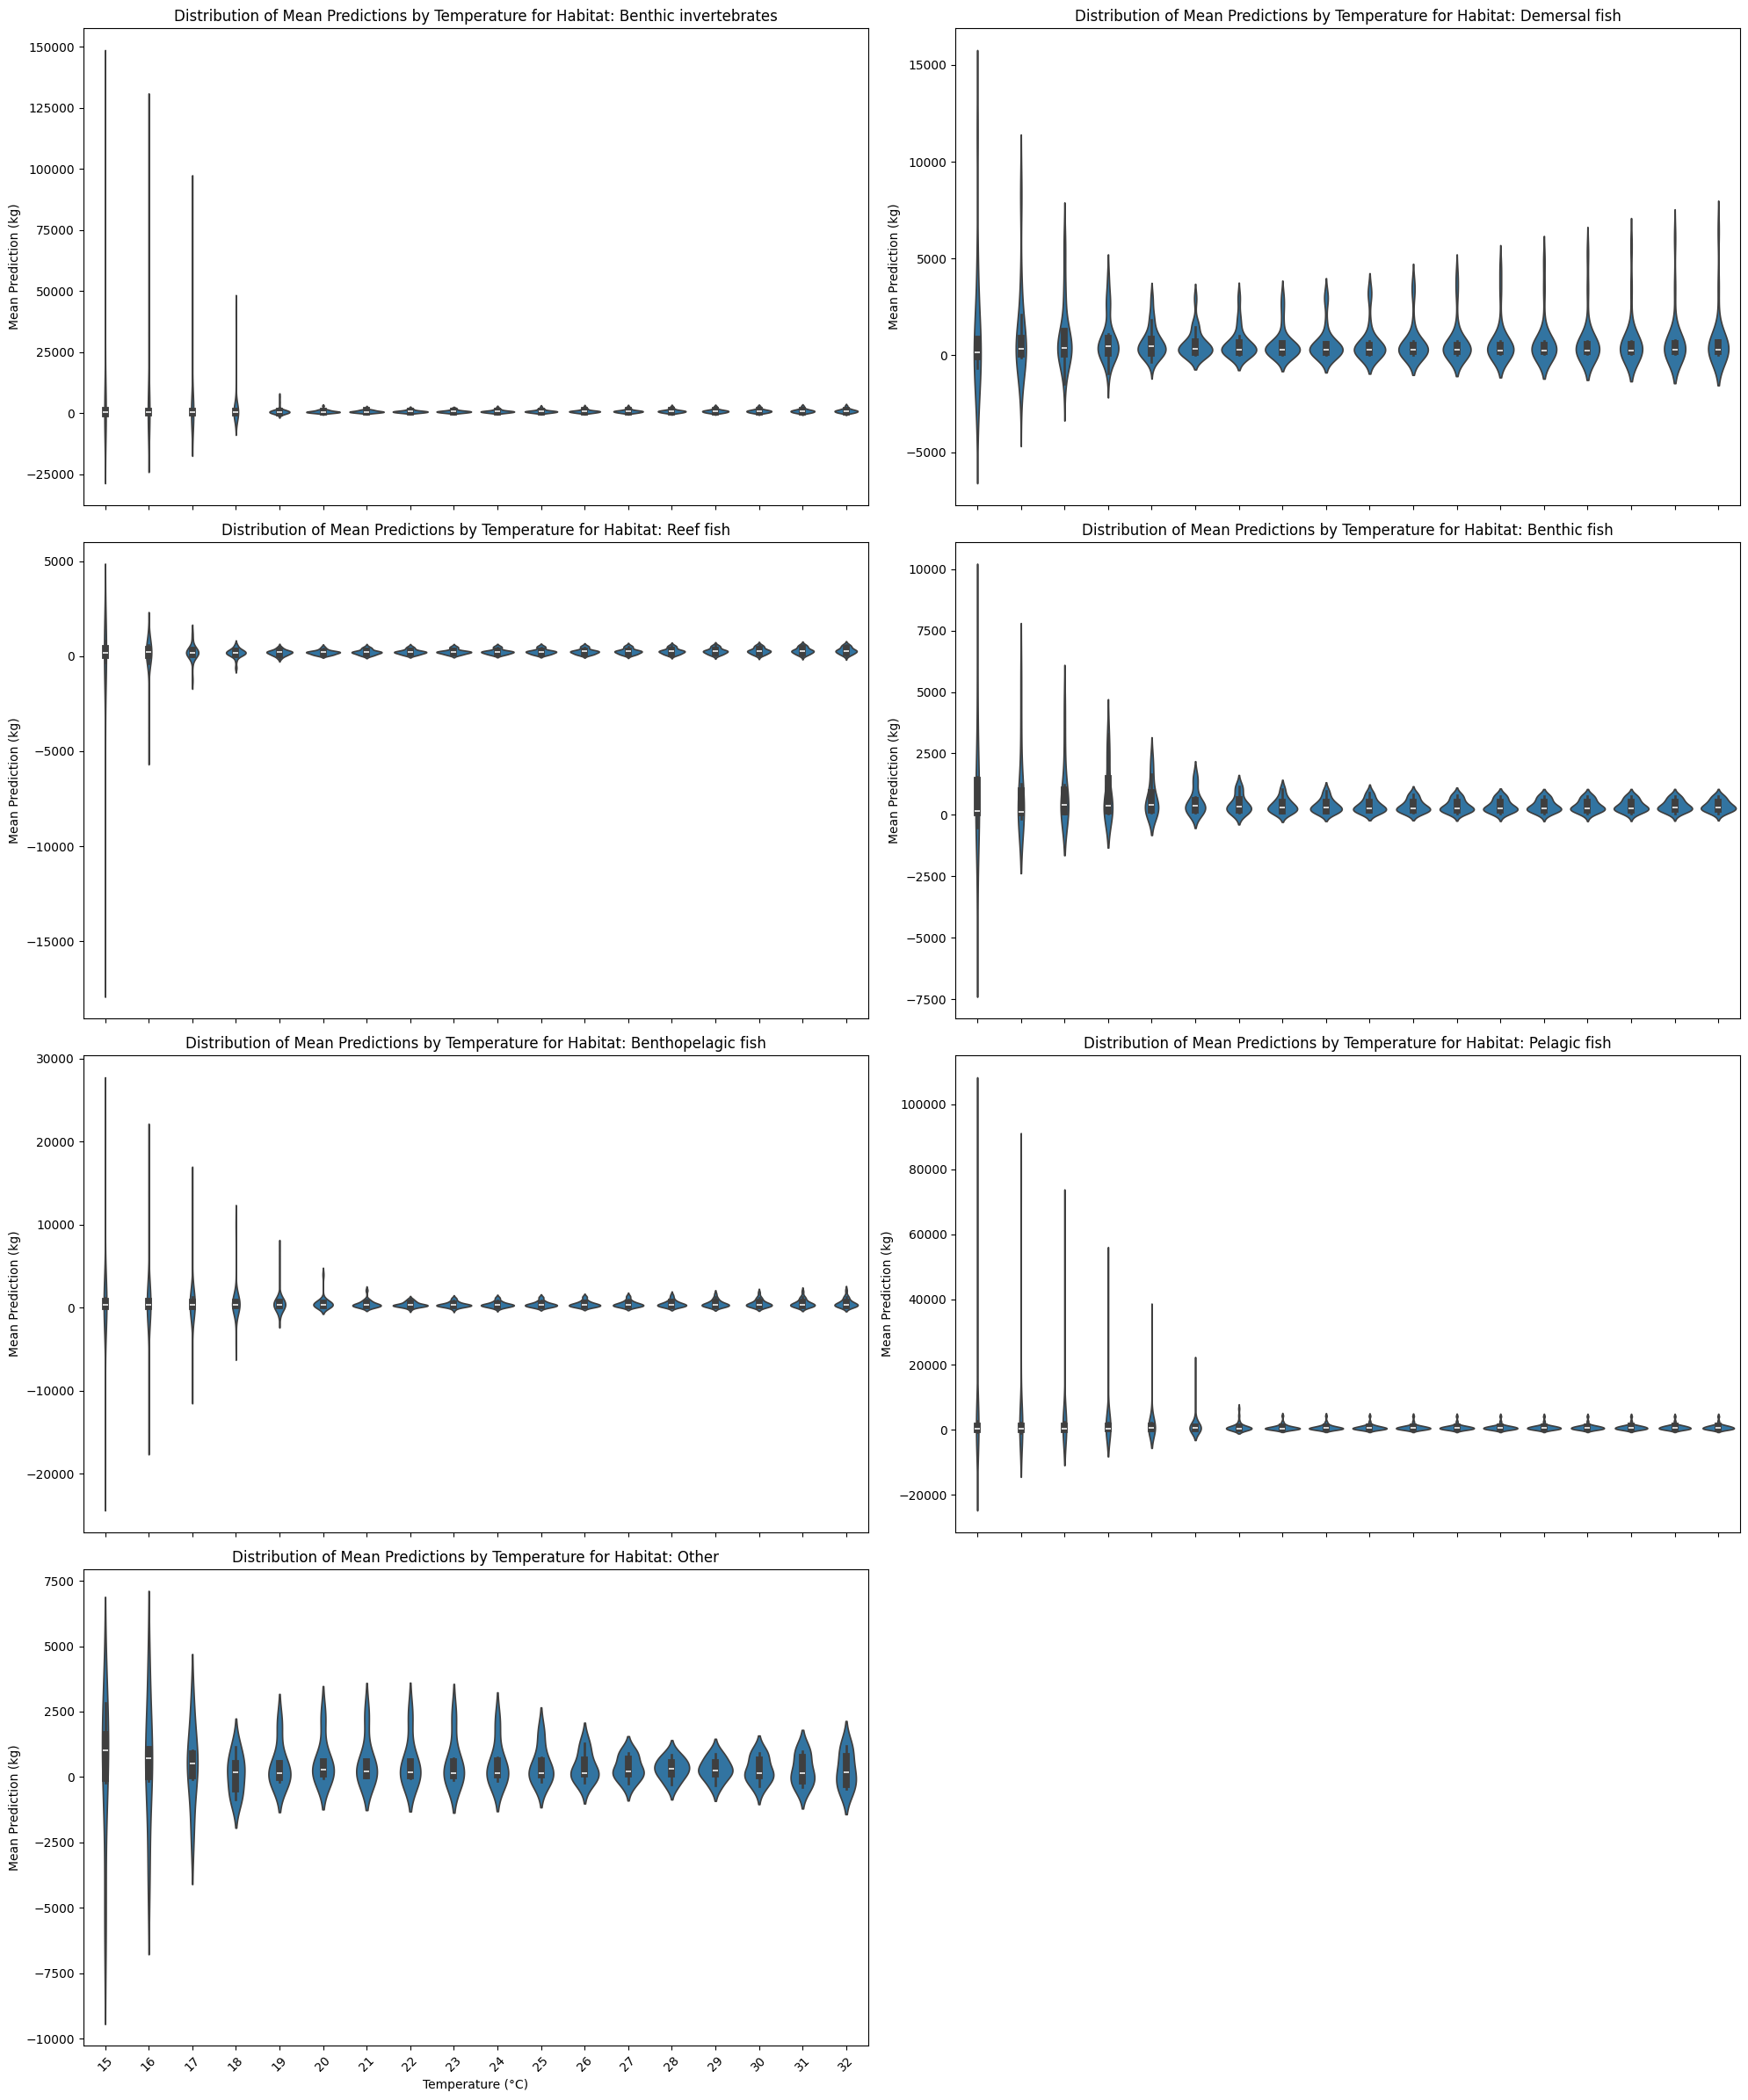

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data from the CSV file
file_path = 'classified_sensitivity_analysis_all.csv'
data = pd.read_csv(file_path)

# Filter out rows with NaN mean_prediction values
filtered_data = data.dropna(subset=['mean_prediction'])

# Set up the figure size for subplots in a 2-column layout
habitats = filtered_data['habitat'].unique()
valid_habitats = [habitat for habitat in habitats if not filtered_data[filtered_data['habitat'] == habitat].empty]
num_valid_habitats = len(valid_habitats)
fig, axes = plt.subplots((num_valid_habitats + 1) // 2, 2, figsize=(20, 6 * ((num_valid_habitats + 1) // 2)), sharex=True)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Create separate violin plots for each valid habitat
for i, habitat in enumerate(valid_habitats):
    ax = axes[i]
    habitat_data = filtered_data[filtered_data['habitat'] == habitat]
    sns.violinplot(data=habitat_data, x='temperature', y='mean_prediction', ax=ax)
    ax.set_title(f'Distribution of Mean Predictions by Temperature for Habitat: {habitat}')
    ax.set_xlabel('Temperature (\u00b0C)')
    ax.set_ylabel('Mean Prediction (kg)')
    ax.tick_params(axis='x', rotation=45)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


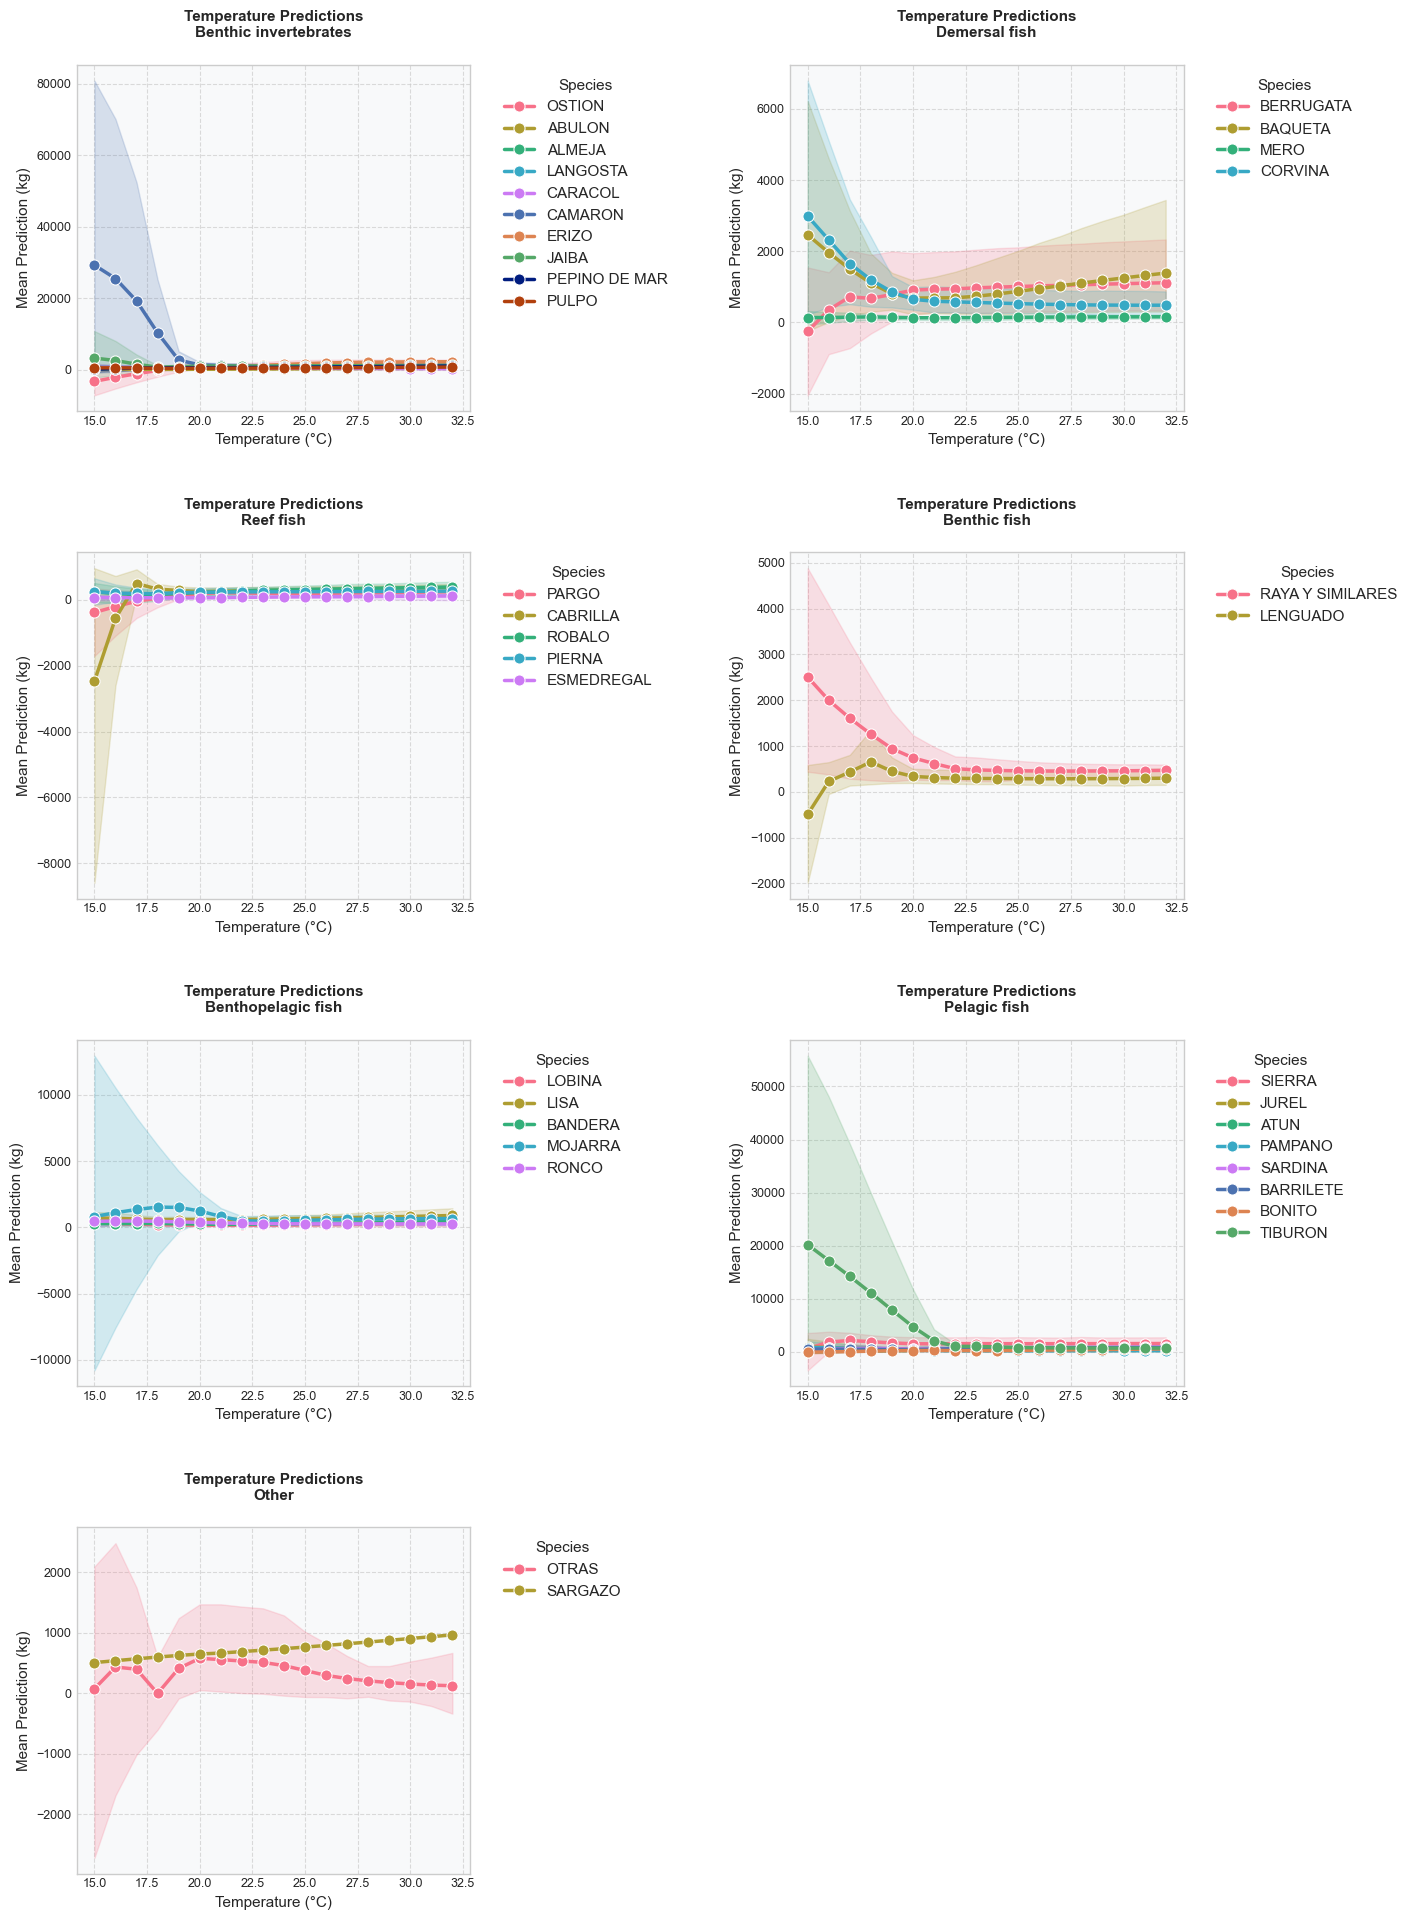

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def create_enhanced_visualization(file_path):
    # Set general seaborn style
    sns.set_style("whitegrid")
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial']
    
    # Load and prepare data
    data = pd.read_csv(file_path)
    filtered_data = data.dropna(subset=['mean_prediction'])
    
    # Create a more diverse color palette
    # Combining different color palettes for more variety
    base_colors = (
        sns.color_palette("husl", 5) +  # Bright, distinct colors
        sns.color_palette("deep", 3) +   # Deep, rich colors
        sns.color_palette("dark", 3) +   # Darker shades
        sns.color_palette("bright", 3)    # Bright, vibrant colors
    )
    
    # Configure subplot layout
    habitats = filtered_data['habitat'].unique()
    valid_habitats = [habitat for habitat in habitats if not filtered_data[filtered_data['habitat'] == habitat].empty]
    num_valid_habitats = len(valid_habitats)
    rows = (num_valid_habitats + 1) // 2
    
    # Create figure with proportional size
    fig = plt.figure(figsize=(15, 5 * rows))
    
    # Create subplots
    for i, habitat in enumerate(valid_habitats, 1):
        ax = plt.subplot(rows, 2, i)
        
        # Filter data for current habitat
        habitat_data = filtered_data[filtered_data['habitat'] == habitat]
        
        # Create line plot with aesthetic improvements
        sns.lineplot(
            data=habitat_data,
            x='temperature',
            y='mean_prediction',
            hue='species',
            palette=base_colors[:len(habitat_data['species'].unique())],
            marker='o',
            markersize=8,
            linewidth=2.5,
            ax=ax
        )
        
        # Customize title and labels
        ax.set_title(f'Temperature Predictions\n{habitat}', 
                    pad=20, 
                    fontsize=11, 
                    fontweight='bold')
        ax.set_xlabel('Temperature (°C)', fontsize=11)
        ax.set_ylabel('Mean Prediction (kg)', fontsize=11)
        
        # Enhance legend
        ax.legend(
            title='Species',
            title_fontsize=11,
            fontsize=11,
            bbox_to_anchor=(1.05, 1),
            loc='upper left'
        )
        
        # Customize axes
        ax.tick_params(axis='both', labelsize=9)
        ax.grid(True, linestyle='--', alpha=0.7)
        
        # Add subtle background
        ax.set_facecolor('#f8f9fa')
    
    # Adjust layout
    plt.tight_layout(pad=3.0)
    return fig

# Usage
file_path = 'classified_sensitivity_analysis_all.csv'
fig = create_enhanced_visualization(file_path)
plt.show()

In [7]:
fig.savefig('temperature_predictions.svg', format='svg', bbox_inches='tight', dpi=300)

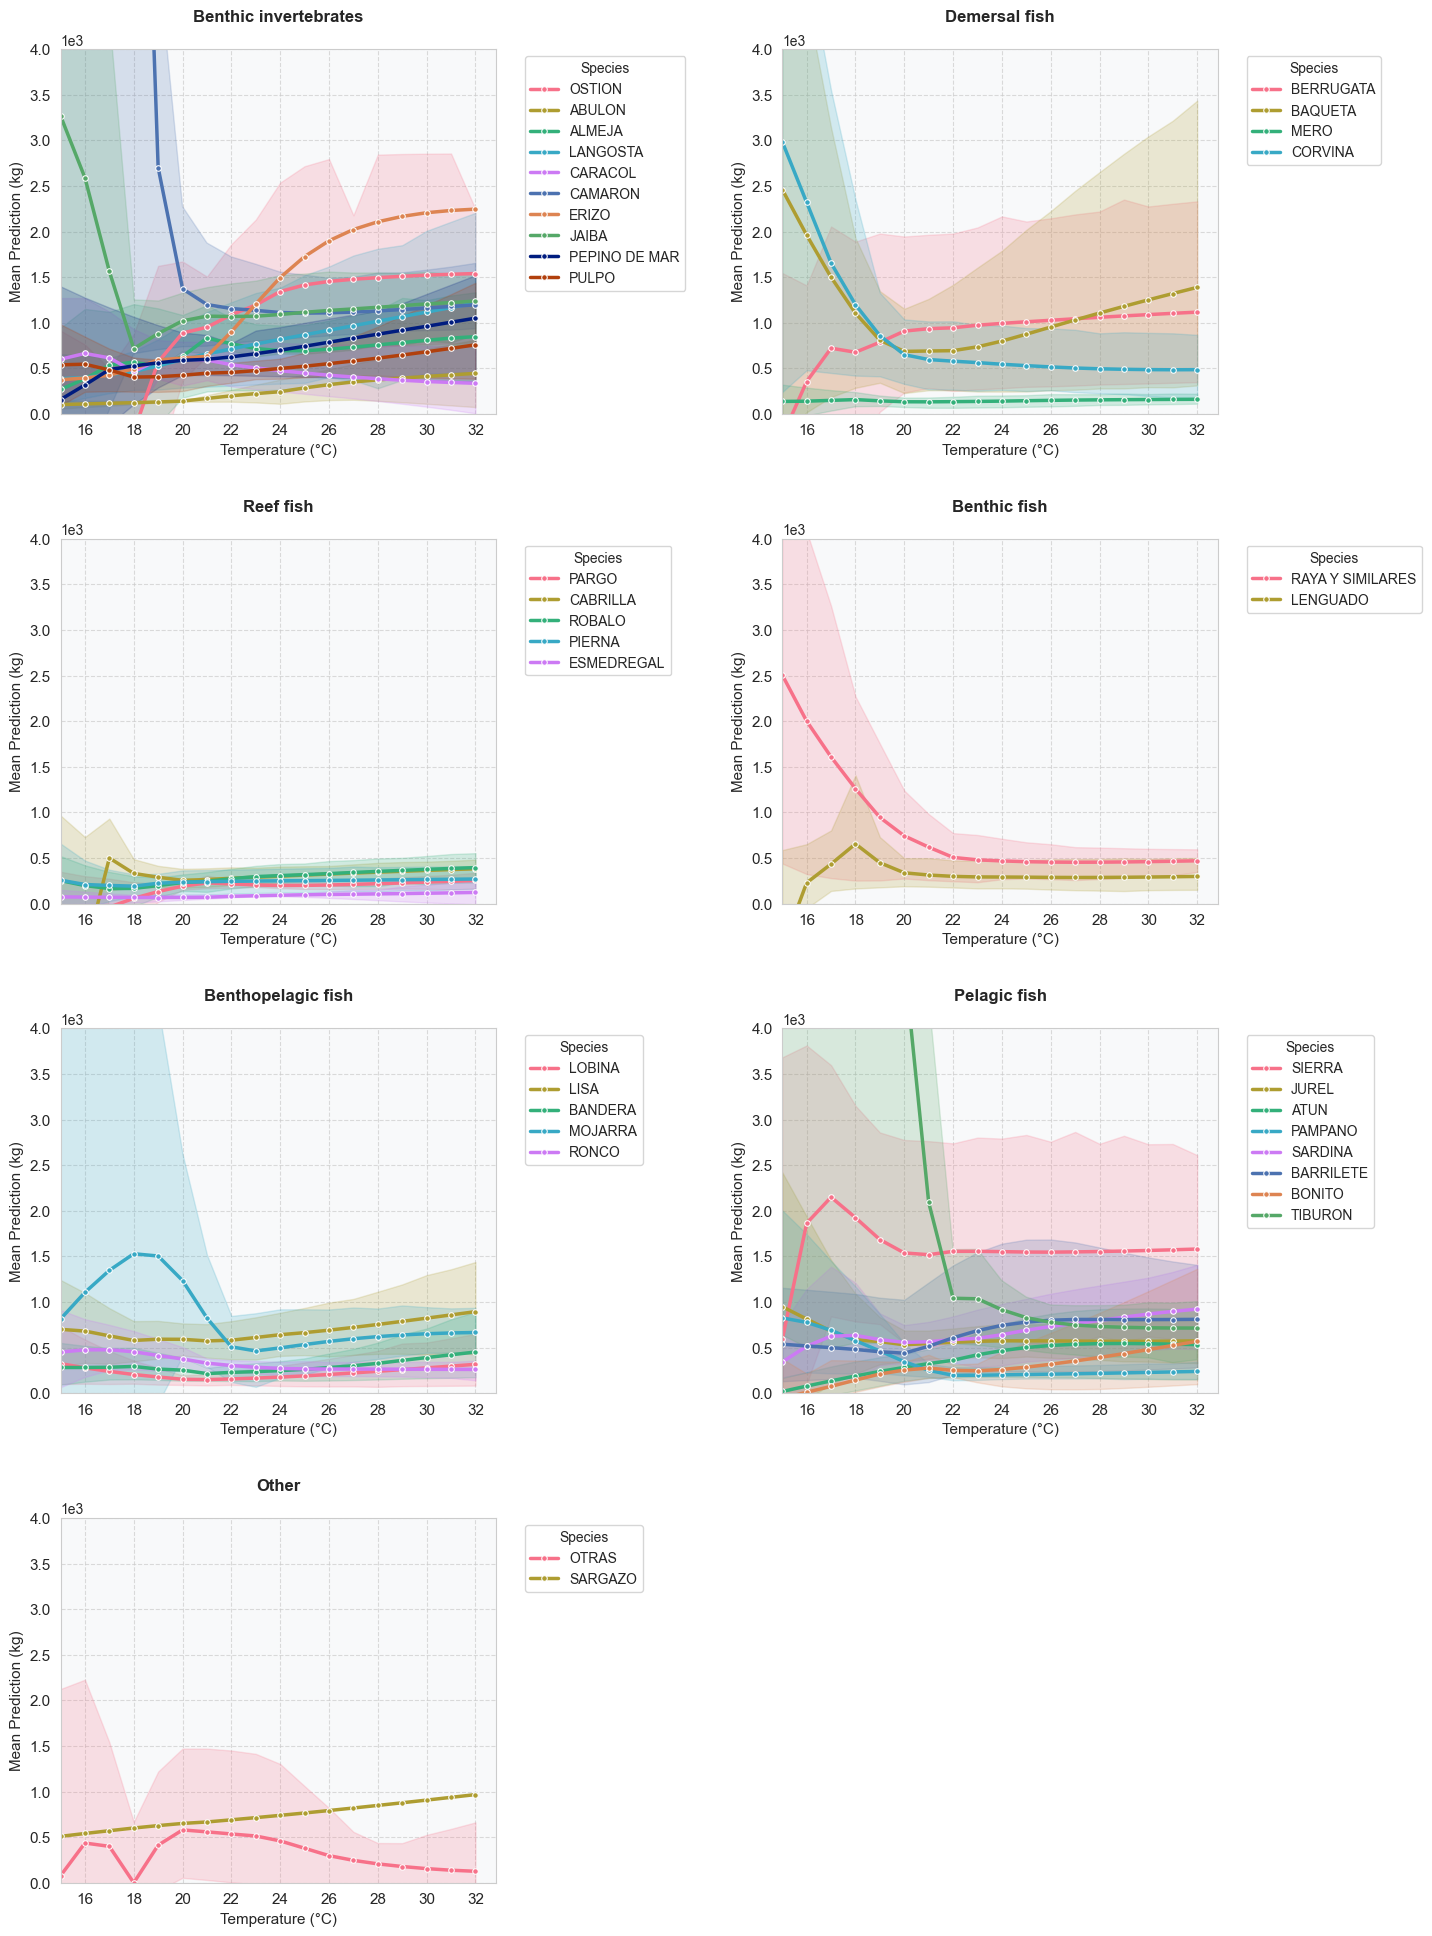

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def create_enhanced_visualization(file_path):
    # Set general seaborn style
    sns.set_style("whitegrid")
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial']
    
    # Load and prepare data
    data = pd.read_csv(file_path)
    filtered_data = data.dropna(subset=['mean_prediction'])
     
    # Create a more diverse color palette
    # Combining different color palettes for more variety
    base_colors = (
        sns.color_palette("husl", 5) +  # Bright, distinct colors
        sns.color_palette("deep", 3) +   # Deep, rich colors
        sns.color_palette("dark", 3) +   # Darker shades
        sns.color_palette("bright", 3)    # Bright, vibrant colors
    )
    
    # Configure subplot layout
    habitats = filtered_data['habitat'].unique()
    valid_habitats = [habitat for habitat in habitats if not filtered_data[filtered_data['habitat'] == habitat].empty]
    num_valid_habitats = len(valid_habitats)
    rows = (num_valid_habitats + 1) // 2
    
    # Create figure with proportional size
    fig = plt.figure(figsize=(15, 5 * rows))
    
    # Create subplots
    for i, habitat in enumerate(valid_habitats, 1):
        ax = plt.subplot(rows, 2, i)
        
        # Filter data for current habitat
        habitat_data = filtered_data[filtered_data['habitat'] == habitat]
        
        # Create line plot with aesthetic improvements
        sns.lineplot(
            data=habitat_data,
            x='temperature',
            y='mean_prediction',
            hue='species',
            palette=base_colors[:len(habitat_data['species'].unique())],
            marker='o',
            markersize=4,  # Reducido de 8 a 4 para hacer los puntos más pequeños
            linewidth=2.5,
            ax=ax
        )
        
        # Customize title and labels
        ax.set_title(f'{habitat}', 
                    pad=20, 
                    fontsize=12, 
                    fontweight='bold')
        ax.set_xlabel('Temperature (°C)', fontsize=11)
        ax.set_ylabel('Mean Prediction (kg)', fontsize=11)
        
        # Enhance legend
        ax.legend(
            title='Species',
            title_fontsize=10,
            fontsize=10,
            bbox_to_anchor=(1.05, 1),
            loc='upper left'
        )
        
        # Customize axes limits
        ax.set_xlim(left=15)  # Set x-axis to start from 17
        ax.set_ylim(0, 4000)  # Set y-axis limits from 0 to 5000
        
        # Customize axes
        ax.tick_params(axis='both', labelsize=11)
        ax.grid(True, linestyle='--', alpha=0.7)
        
        # Cambiar el eje Y a notación científica
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        
        # Add subtle background
        ax.set_facecolor('#f8f9fa')
    
    # Adjust layout
    plt.tight_layout(pad=3.0)
    return fig

# Usage
file_path = 'classified_sensitivity_analysis_all.csv'
fig = create_enhanced_visualization(file_path)
plt.show()
fig.savefig('figures/temperature_predictions.svg', format='svg', bbox_inches='tight', dpi=300)

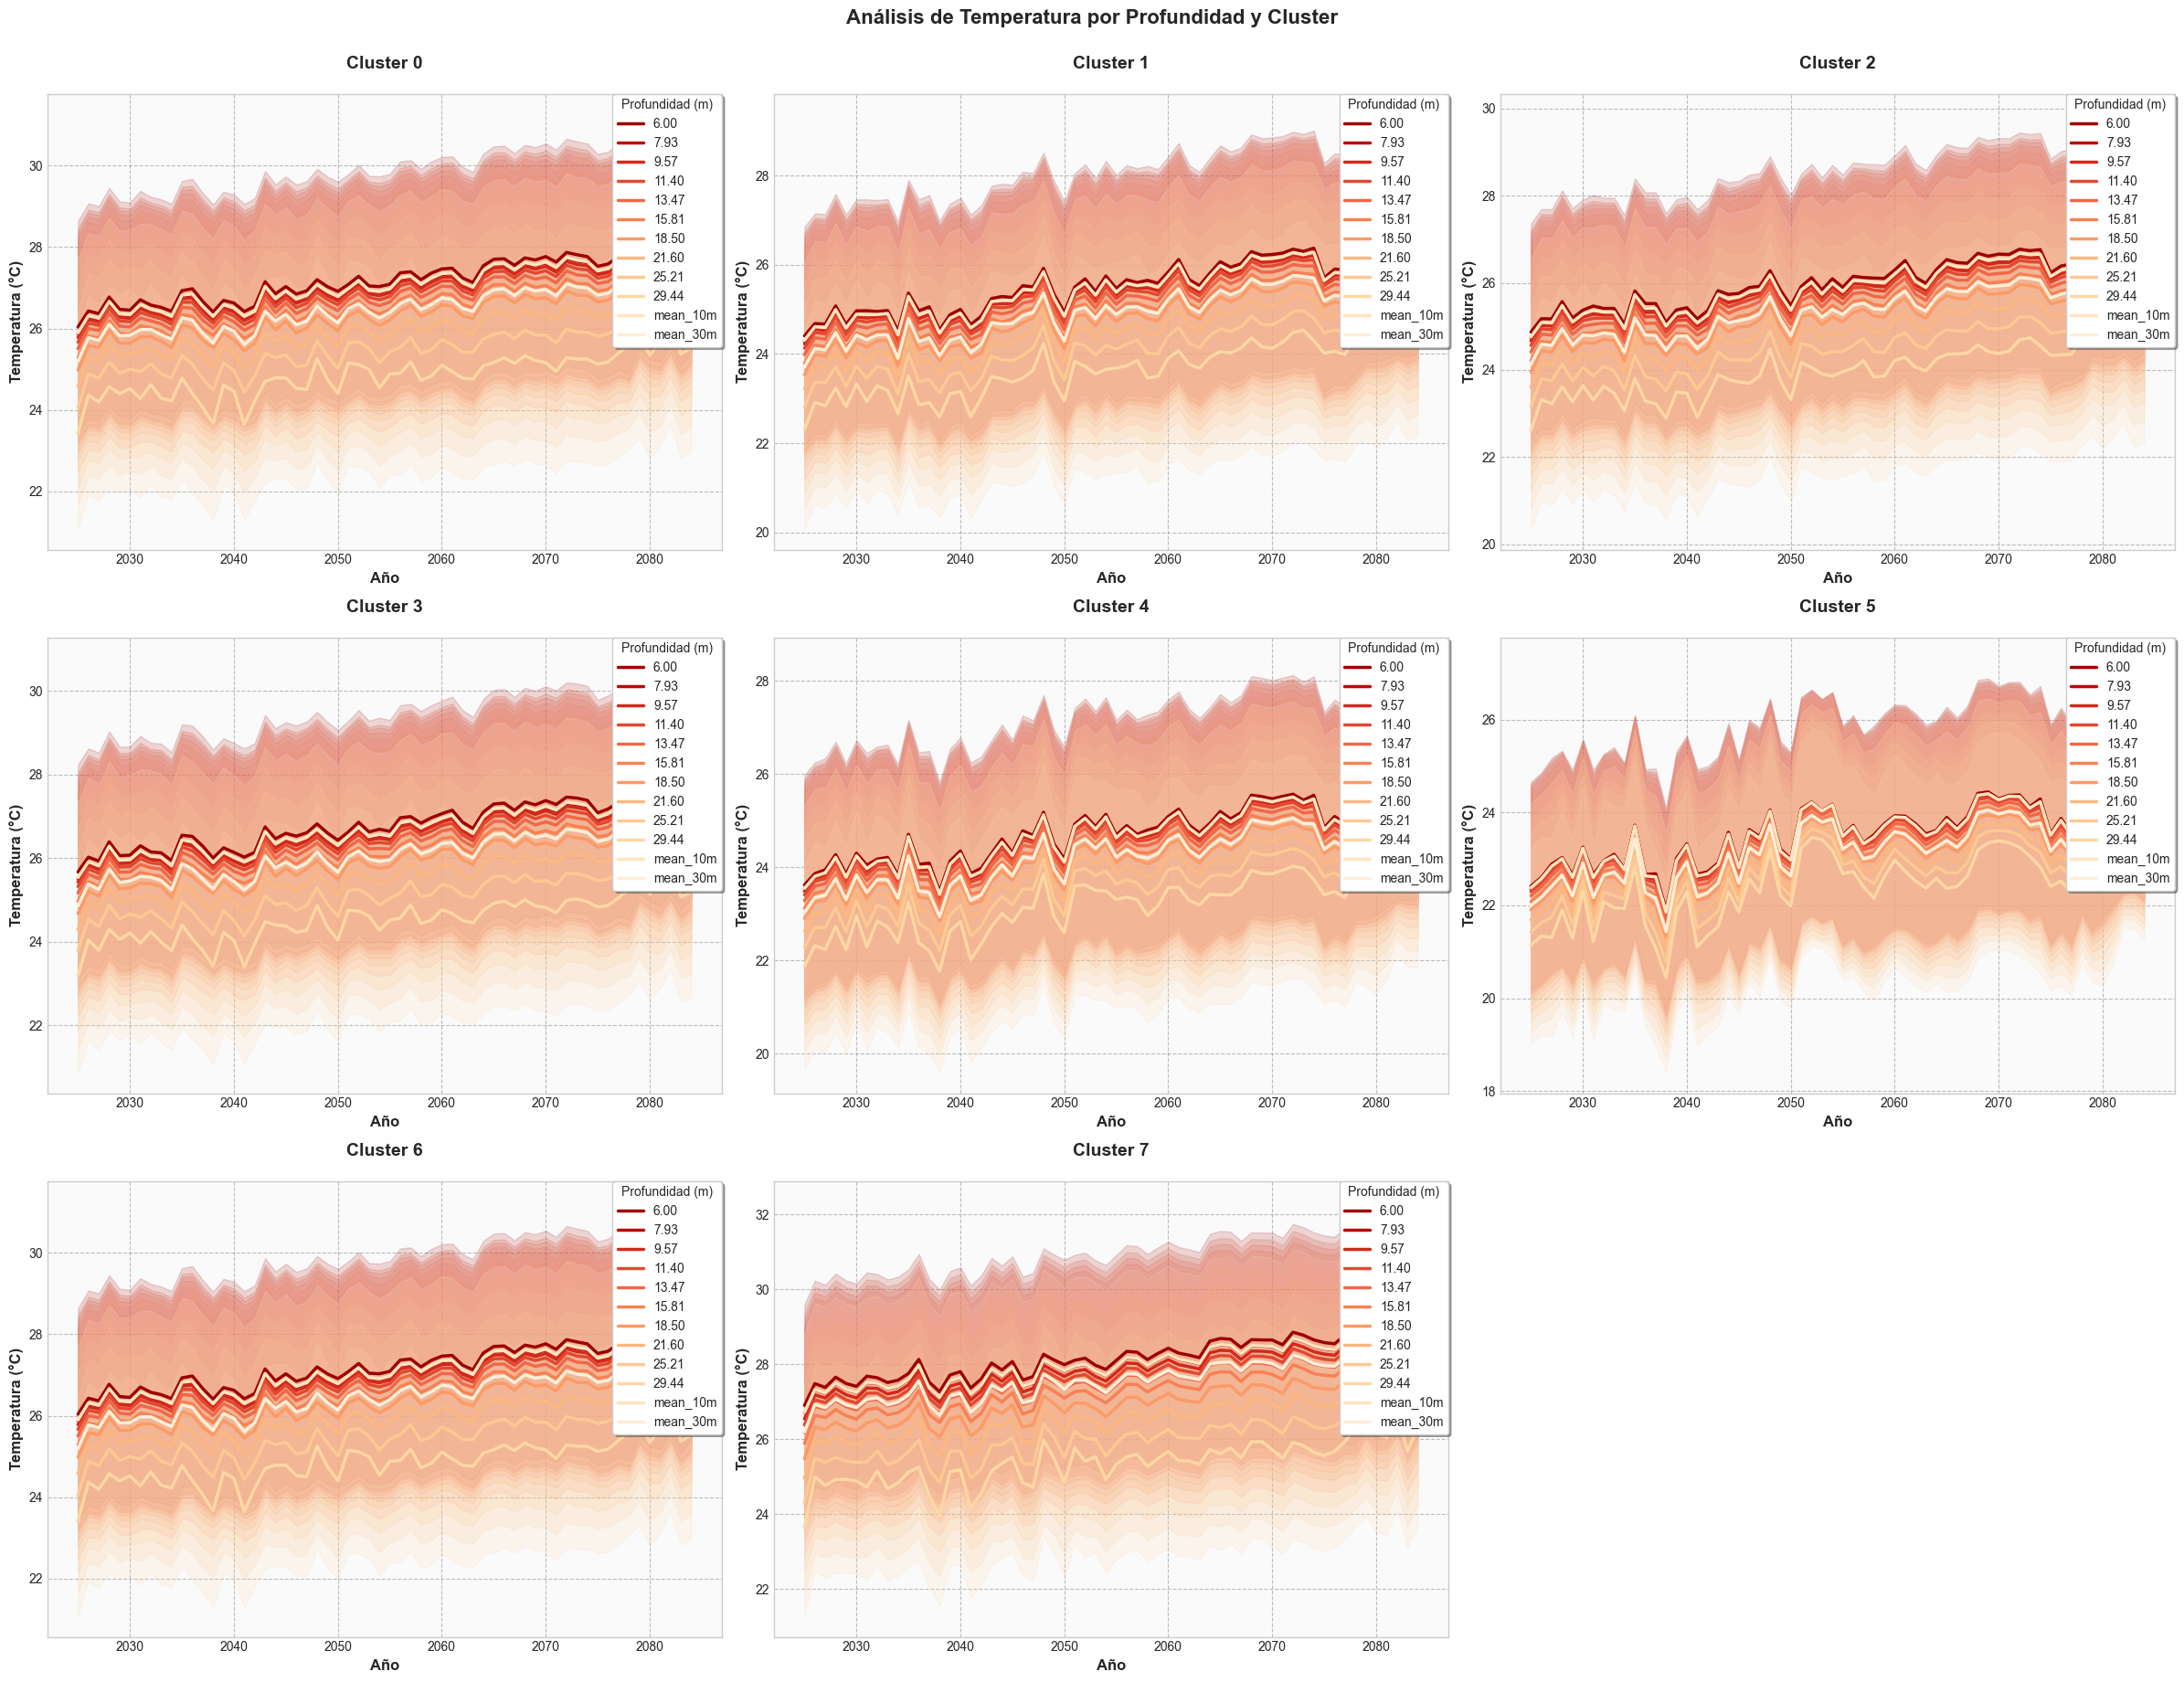

<Figure size 1400x800 with 0 Axes>

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math



# Cargar los datos
file_path = 'future_data.csv'
data = pd.read_csv(file_path)
data['Year'] = data['year']

# Agrupar datos
grouped_data = data.groupby(['Year', 'cluster']).mean().reset_index()
depth_columns = [col for col in data.columns if 'depth_' in col]
clusters = sorted(grouped_data['cluster'].unique())

# Calcular el número de filas necesarias para 3 columnas
n_rows = math.ceil(len(clusters) / 3)

# Crear la figura con un tamaño apropiado para 3 columnas
fig = plt.figure(figsize=(24, 6*n_rows))

# Crear una paleta personalizada de naranjas a negros (en orden inverso)
colors = ['#000000', '#450000', '#8B0000', '#FF4500', '#FF8C00', '#FFB84C']
if len(depth_columns) > len(colors):
    # Si hay más profundidades que colores, interpolar
    colors = sns.color_palette('OrRd', n_colors=len(depth_columns))
    colors = colors[::-1]  # Invertir el orden

# Función para añadir bandas de confianza
def add_confidence_bands(ax, x, y, color, alpha=0.15):
    z = np.polyfit(x, y, 3)
    p = np.poly1d(z)
    ax.fill_between(x, y-y*0.1, y+y*0.1, color=color, alpha=alpha)
    return p(x)

for i, cluster in enumerate(clusters, 1):
    # Filtrar datos para el cluster específico
    cluster_data = grouped_data[grouped_data['cluster'] == cluster]
    
    # Crear el subplot en una cuadrícula de 3 columnas
    ax = plt.subplot(n_rows, 3, i)
    
    # Graficar las líneas de temperatura con mejoras
    for j, depth in enumerate(depth_columns):
        line = ax.plot(cluster_data['Year'], 
                      cluster_data[depth], 
                      label=depth.replace('depth_', ''),
                      color=colors[j],
                      linewidth=2.5)
        
        # Añadir bandas de confianza
        trend = add_confidence_bands(ax, 
                                   cluster_data['Year'], 
                                   cluster_data[depth], 
                                   colors[j])
    
    # Personalizar el gráfico
    ax.set_xlabel('Año', fontsize=12, fontweight='bold')
    ax.set_ylabel('Temperatura (°C)', fontsize=12, fontweight='bold')
    ax.set_title(f'Cluster {cluster}',
                 fontsize=14, 
                 fontweight='bold', 
                 pad=20)
    
    # Añadir grid con estilo
    ax.grid(True, linestyle='--', alpha=0.5, color='gray')
    
    # Personalizar leyenda
    legend = ax.legend(title='Profundidad (m)', 
                      loc='upper right',
                      borderaxespad=0,
                      frameon=True,
                      fancybox=True,
                      shadow=True,
                      fontsize=10)
    
    # Personalizar el fondo del gráfico
    ax.set_facecolor('#FAFAFA')

# Ajustar el layout
plt.tight_layout()

# Añadir un título general
fig.suptitle('Análisis de Temperatura por Profundidad y Cluster',
             fontsize=16,
             fontweight='bold',
             y=1.02)

plt.show()

# Guardar la figura con alta resolución
plt.savefig('temperature_analysis.png', 
            dpi=300, 
            bbox_inches='tight', 
            pad_inches=0.5)

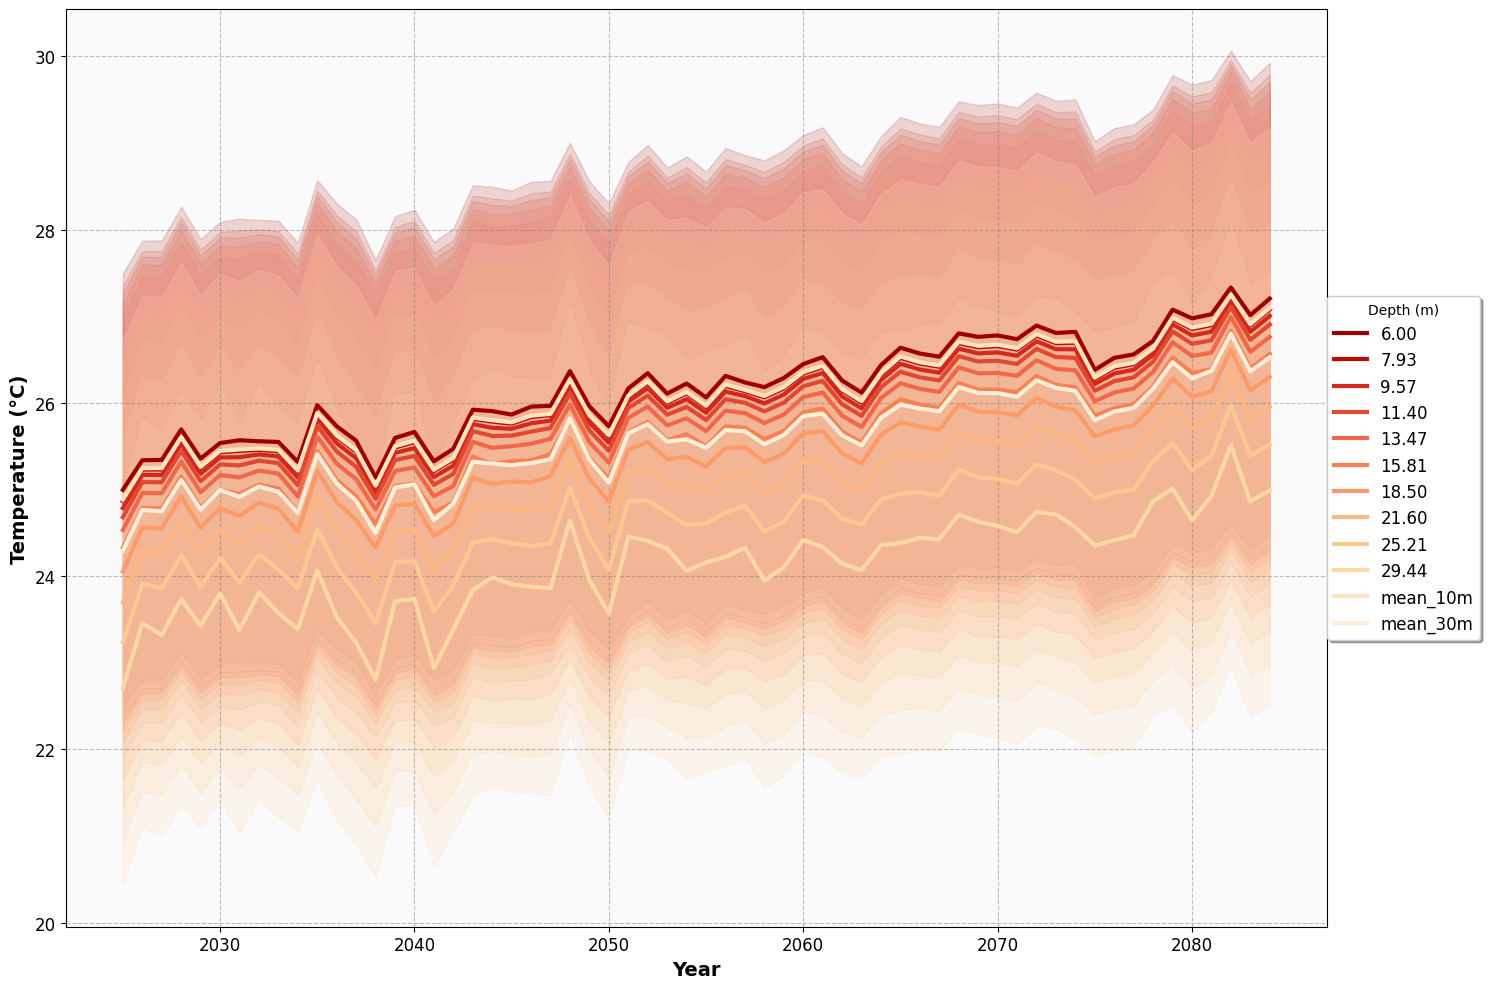

<Figure size 640x480 with 0 Axes>

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np




# Cargar los datos
file_path = 'future_data.csv'
data = pd.read_csv(file_path)
data['Year'] = data['year']

# Agrupar datos solo por año (promediando todos los clusters)
grouped_data = data.groupby(['Year']).mean().reset_index()
depth_columns = [col for col in data.columns if 'depth_' in col]

# Crear la figura
fig = plt.figure(figsize=(15, 10))

# Crear una paleta personalizada de naranjas a negros (en orden inverso)
colors = ['#000000', '#450000', '#8B0000', '#FF4500', '#FF8C00', '#FFB84C']
if len(depth_columns) > len(colors):
    colors = sns.color_palette('OrRd', n_colors=len(depth_columns))
    colors = colors[::-1]  # Invertir el orden

# Función para añadir bandas de confianza
def add_confidence_bands(ax, x, y, color, alpha=0.15):
    z = np.polyfit(x, y, 3)
    p = np.poly1d(z)
    ax.fill_between(x, y-y*0.1, y+y*0.1, color=color, alpha=alpha)
    return p(x)

# Crear el gráfico principal
ax = plt.gca()

# Graficar las líneas de temperatura con mejoras
for j, depth in enumerate(depth_columns):
    line = ax.plot(grouped_data['Year'], 
                  grouped_data[depth], 
                  label=depth.replace('depth_', ''),
                  color=colors[j],
                  linewidth=3.0)
    
    # Añadir bandas de confianza
    trend = add_confidence_bands(ax, 
                               grouped_data['Year'], 
                               grouped_data[depth], 
                               colors[j])

# Personalizar el gráfico
ax.set_xlabel('Year', fontsize=14, fontweight='bold')
ax.set_ylabel('Temperature (°C)', fontsize=14, fontweight='bold')
#ax.set_title('Temperatura Promedio Anual por Profundidad\n(Promedio de todos los clusters)',
#             fontsize=16, 
#             fontweight='bold', 
#             pad=20)

# Añadir grid con estilo
ax.grid(True, linestyle='--', alpha=0.5, color='gray')

# Personalizar leyenda
legend = ax.legend(title='Depth (m)', 
                  loc='center left',
                  bbox_to_anchor=(1, 0.5),
                  borderaxespad=0,
                  frameon=True,
                  fancybox=True,
                  shadow=True,
                  fontsize=12)

# Personalizar el fondo del gráfico
ax.set_facecolor('#FAFAFA')

# Mejorar los ticks
ax.tick_params(axis='both', which='major', labelsize=12)

# Ajustar el layout
plt.tight_layout()

plt.show()

# Guardar la figura con alta resolución
plt.savefig('temperature_analysis_averaged.png', 
            dpi=300, 
            bbox_inches='tight', 
            pad_inches=0.5)

In [17]:
import pandas as pd
import numpy as np

def classify_changes(baseline, future):
    """
    Clasifica el cambio como incremento, decremento o estable
    """
    percent_change = ((future - baseline) / baseline) * 100
    threshold = 5  # Umbral del 5% para considerar un cambio significativo
    
    if percent_change <= -threshold:
        return 'decremento'
    elif percent_change >= threshold:
        return 'incremento'
    else:
        return 'estable'

def determine_scenario(changes_dict):
    """
    Determina el escenario basado en los cambios en los diferentes hábitats
    """
    changes = list(changes_dict.values())
    
    # Escenario a: todos presentan decrementos
    if all(change == 'decremento' for change in changes):
        return 'Escenario a: Decrementos en todas las capturas'
    
    # Escenario e: todos permanecen estables
    if all(change == 'estable' for change in changes):
        return 'Escenario e: Capturas estables en todos los grupos'
    
    # Escenario b: algunos decrementos, otros estables
    if all(change in ['decremento', 'estable'] for change in changes) and \
       any(change == 'decremento' for change in changes):
        return 'Escenario b: Decrementos en algunos grupos, otros estables'
    
    # Escenario c: mix de decrementos e incrementos
    if 'incremento' in changes and 'decremento' in changes:
        return 'Escenario c: Mix de decrementos e incrementos'
    
    # Escenario d: incrementos insuficientes
    if any(change == 'incremento' for change in changes) and \
       not any(change == 'decremento' for change in changes):
        return 'Escenario d: Incrementos insuficientes'
    
    return 'No clasificable'

# Cargar y preparar datos
data = pd.read_csv('future_catches.csv')
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year

# Filtrar datos hasta 2050
data = data[data['year'] <= 2060]

# Calcular línea base (promedio 2020-2030) y futuro (promedio 2040-2050)
baseline = data[(data['year'] >= 2020) & (data['year'] <= 2030)].groupby(
    ['Cluster', 'habitat'])['predictions'].mean().reset_index()
future = data[(data['year'] >= 2040) & (data['year'] <= 2060)].groupby(
    ['Cluster', 'habitat'])['predictions'].mean().reset_index()

# Combinar datos de línea base y futuro
comparison = pd.merge(baseline, future, 
                     on=['Cluster', 'habitat'], 
                     suffixes=('_baseline', '_future'))

# Clasificar cambios para cada cluster y hábitat
results = []
for cluster in comparison['Cluster'].unique():
    cluster_data = comparison[comparison['Cluster'] == cluster]
    changes = {}
    
    for _, row in cluster_data.iterrows():
        changes[row['habitat']] = classify_changes(
            row['predictions_baseline'], 
            row['predictions_future']
        )
    
    scenario = determine_scenario(changes)
    
    # Agregar detalles por hábitat
    habitat_details = []
    for habitat, change in changes.items():
        baseline_val = cluster_data[cluster_data['habitat'] == habitat]['predictions_baseline'].values[0]
        future_val = cluster_data[cluster_data['habitat'] == habitat]['predictions_future'].values[0]
        percent_change = ((future_val - baseline_val) / baseline_val) * 100
        habitat_details.append(f"{habitat}: {change} ({percent_change:.1f}%)")
    
    results.append({
        'Cluster': cluster,
        'Escenario': scenario,
        'Detalles': ' | '.join(habitat_details)
    })

# Crear DataFrame con resultados
results_df = pd.DataFrame(results)

# Mostrar resultados
print("\nClasificación de Escenarios por Cluster:")
print("=" * 80)
for _, row in results_df.iterrows():
    print(f"\nCluster: {row['Cluster']}")
    print(f"Escenario: {row['Escenario']}")
    print(f"Detalles de cambios por hábitat:")
    print(row['Detalles'])

# Conteo de escenarios
print("\nResumen de Dominancia de Escenarios:")
print("=" * 80)
scenario_counts = results_df['Escenario'].value_counts()
for scenario, count in scenario_counts.items():
    percentage = (count / len(results_df)) * 100
    print(f"{scenario}: {count} clusters ({percentage:.1f}%)")


Clasificación de Escenarios por Cluster:

Cluster: 0
Escenario: Escenario d: Incrementos insuficientes
Detalles de cambios por hábitat:
Benthic invertebrates: incremento (12.5%)

Cluster: 1
Escenario: Escenario c: Mix de decrementos e incrementos
Detalles de cambios por hábitat:
Benthic fish: decremento (-14.6%) | Benthic invertebrates: estable (4.3%) | Benthopelagic fish: incremento (5.9%)

Cluster: 3
Escenario: Escenario b: Decrementos en algunos grupos, otros estables
Detalles de cambios por hábitat:
Benthic invertebrates: decremento (-12.8%) | Pelagic fish: decremento (-10.0%) | Reef fish: estable (0.5%)

Cluster: 4
Escenario: Escenario a: Decrementos en todas las capturas
Detalles de cambios por hábitat:
Benthic invertebrates: decremento (-5.0%) | Pelagic fish: decremento (-12.2%)

Cluster: 6
Escenario: Escenario e: Capturas estables en todos los grupos
Detalles de cambios por hábitat:
Benthic invertebrates: estable (-0.8%) | Demersal fish: estable (3.7%) | Reef fish: estable (-0